# Applying Machine Learning Models

In [2]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datetime import datetime

from sklearn import linear_model
# metrics: 計測 → 評価
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
# カーネルなしSVM（SVC: Support Vector Classifierの略）
from sklearn.svm import LinearSVC
# カーネル法を用いたSVM
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier


In [3]:
train = pd.read_csv('UCI_HAR_Dataset/csv_files/train.csv')
test = pd.read_csv('UCI_HAR_Dataset/csv_files/test.csv')
print(train.shape, test.shape)

(7352, 564) (2947, 564)


In [4]:
train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity,ActivityName
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,5,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,5,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,5,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,5,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,5,STANDING


In [5]:
df_concat = pd.concat([train, test])

print(df_concat.shape)


(10299, 564)


## Making Data for Model

In [6]:
from sklearn.model_selection import train_test_split

X = df_concat.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y = df_concat['ActivityName']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# # 訓練用
# X_train = train.drop(['subject', 'Activity', 'ActivityName'], axis=1)
# y_train = train['subject']

# # テスト用
# X_test = test.drop(['subject', 'Activity', 'ActivityName'], axis=1)
# y_test = test['subject']

print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))

# for i in X_train.columns:
#       print(X_train[i].dtype)
# print(X_train.dtypes)

X_train and y_train : ((6900, 561),(6900,))
X_test  and y_test  : ((3399, 561),(3399,))


Labels that are usuful in plotting confusion matrix

In [6]:
labels = ['LAYING', 'SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']

Let's make a function to plot the confusion matrix

In [7]:
plt.rcParams['font.family'] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    # normalize → 正規化
    if normalize:
        # cmの値は予測結果と実際の値の一致数なので，それを列の合計で割ると確率
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # np.newaxisは次元を追加
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # plt.text(): 座標（x, y），表示するテキスト，文字位置，色指定
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Let's make a function to run any model specified

In [8]:
# 任意のモデルを実行
def perform_model(model, X_train, y_train, X_test, y_test, class_labels, cm_nomalize=True, print_cm=True, cm_cmap=plt.cm.Greens):
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model...')
    model.fit(X_train, y_train)
    print('Done')
    train_end_time = datetime.now()
    results['training_time'] = train_end_time - train_start_time
    print('==> training time:- {}\n'.format(results['training_time']))
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    results['testing_time'] = test_end_time - test_start_time
    print('==> testing time:- {}\n'.format(results['testing_time']))
    # 予測結果を格納
    results['predicted'] = y_pred
    
    # calculate overall accuracy of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('==> Accuracy:- {}\n'.format(accuracy))
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    # output confusion matrix
    if print_cm:
        print('\n ********Confusion Matrix********')
        print('\n {}'.format(cm))
    
    # plot confusion matrix
    plt.figure(figsize=(6, 6))
    plt.grid(b=False) # グリッドを非表示
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized Confusion Matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    print('****************| Classifiction Report |****************')
    classification_report = metrics.classification_report(y_test, y_pred)
    
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained model to the results
    results['model'] = model
    
    return results
    

In [22]:
# 任意のモデルを実行
def perform_model_epsilon(model, X_train, y_train, X_test, y_test, class_labels, cm_nomalize=True, print_cm=True, cm_cmap=plt.cm.Greens):
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model...')
    model.fit(X_train, y_train)
    print('Done')
    train_end_time = datetime.now()
    results['training_time'] = train_end_time - train_start_time
    print('==> training time:- {}\n'.format(results['training_time']))
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    results['testing_time'] = test_end_time - test_start_time
    print('==> testing time:- {}\n'.format(results['testing_time']))
    # 予測結果を格納
    results['predicted'] = y_pred
    
    # calculate overall accuracy of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    # store accuracy in results
    results['accuracy'] = accuracy
    print('==> Accuracy:- {}\n'.format(accuracy))
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    # output confusion matrix
    if print_cm:
        print('\n ********Confusion Matrix********')
        print('\n {}'.format(cm))
    
    # plot confusion matrix
    plt.figure(figsize=(15, 15))
    plt.grid(b=False) # グリッドを非表示
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized Confusion Matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    # print('****************| Classifiction Report |****************')
    # classification_report = metrics.classification_report(y_test, y_pred)
    
    # # store report in results
    # results['classification_report'] = classification_report
    # print(classification_report)
    
    # get f1 score
    f1 = metrics.f1_score(y_test, y_pred, average="macro")
    print("\n F1 Score:{}".format(f1))
    
    # add the trained model to the results
    results['model'] = model
    
    return results, f1
    

Make function to print the gridsearch Parameters

In [9]:
# 同一モデルでの値を表示
def print_grid_search_attributes(model):
    
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('\n\n==> Best Estimator:')
    print('\t{}\n'.format(model.best_estimator_))
    
    # parameters that gave best results while perfoming grid search
    print('\n==> Best parameters:')
    print('\tParameters of best estimator : {}'.format(model.best_params_))
    
    # number of cross validation splits
    print('\n==> No. of CrossValidation sets:')
    print('\tTotal nmber of cross validation sets: {}'.format(model.n_splits_))
    
    # Average cross validated score of the best estimator, from the Grid Search
    print('\n==> Best Score:')
    print('\tAverage Cross Validate scores of Best estimator : {}'.format(model.best_score_))

## 1. Logistic Regression with Grid Search

[グリッドサーチ参考サイト](https://data-analysis-stats.jp/機械学習/grid-search-のパラメタチューニング/)

training the model...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Done
==> training time:- 0:02:07.509760

Predicting test data
==> testing time:- 0:00:00.190622

==> Accuracy:- 0.9796999117387467


 ********Confusion Matrix********

 [[661   0   0   0   0   0]
 [  1 585  29   0   0   4]
 [  0  26 579   0   0   0]
 [  0   0   0 590   1   1]
 [  0   0   0   3 451   2]
 [  0   0   0   2   0 464]]


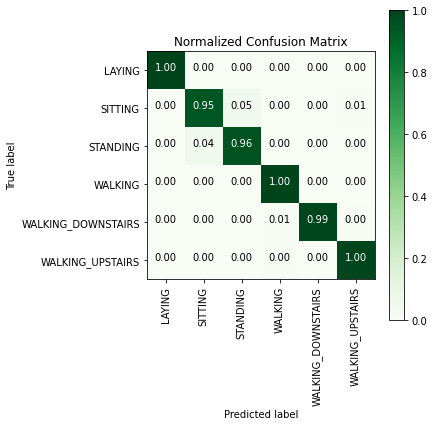

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       661
           SITTING       0.96      0.95      0.95       619
          STANDING       0.95      0.96      0.95       605
           WALKING       0.99      1.00      0.99       592
WALKING_DOWNSTAIRS       1.00      0.99      0.99       456
  WALKING_UPSTAIRS       0.99      1.00      0.99       466

          accuracy                           0.98      3399
         macro avg       0.98      0.98      0.98      3399
      weighted avg       0.98      0.98      0.98      3399



==> Best Estimator:
	LogisticRegression(C=1, random_state=0)


==> Best parameters:
	Parameters of best estimator : {'C': 1, 'penalty': 'l2'}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.981159420289855


In [25]:
'''
GridSearchCVのパラメータ

estimator : estimator object
チューニングを行うモデル

param_grid : dict or list of dictionaries
パラメタ候補値を「パラメタ名, 候補値リスト」の辞書で与える

scoring : string, callable, list/tuple, dict or None, default: None
複数のメトリックを評価するには、文字例のリストか、の辞書で与える

n_jobs : int or None, optional (default=None)
同時実行数(-1にするとコア数で同時実行)

pre_dispatch : int, or string, optional
同時実行数にディスパッチされるジョブの数を設定する

iid : boolean, default=’warn’
Trueの場合、各テストセットのサンプル数で重み付けされた、折り畳み全体の平均スコアを返す

cv : int, cross-validation generator or an iterable, optional
Cross validationの分割数(デフォルト値は3)

refit : boolean, string, or callable, default=True
Trueだと最良だったパラメタを使い学習データ全体で再学習する

verbose : integer
ログ出力レベル（高ければ高いほど、長い出力）

error_score : ‘raise’ or numeric
エラーが発生した場合にスコアに割り当てる値。

return_train_score : boolean, default=False
Falseの場合は、トレーニングスコアを含まない
'''


import warnings
# 収束しなかった場合のwarning
from sklearn.exceptions import ConvergenceWarning
# warningを無視する
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

# start Grid search
# C: 正則化項の係数（正則化の強さの逆数）
# penalty: 正則化をL1ノルムでやるかL2ノルムでやるかを，l1 または l2 から選択
param_grid = [{
    'C': [0.01, 0.1, 1, 10, 20, 30],
    'penalty': ['l2', 'l1']
}]


log_reg = linear_model.LogisticRegression(random_state=0)
log_reg_grid = GridSearchCV(log_reg, param_grid=param_grid, cv=5, verbose=1, n_jobs=1)
log_reg_grid_results, f1 = perform_model_epsilon(log_reg_grid, X_train.values, y_train.values, X_test.values, y_test.values, class_labels=labels)

# observe the attributes of the model
print_grid_search_attributes(log_reg_grid_results['model'])

## 1. Logistic Regression in Noise
[ラプラスノイズ 参考サイト](https://numpy.org/doc/stable/reference/random/generated/numpy.random.laplace.html)
> numpy.random.laplace( μ, b, size)<br>
μ: 平均, b: スケール, size: 出力サイズ(次元)

As epsilon = 0.01
training the model...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Done
==> training time:- 0:01:12.589540

Predicting test data
==> testing time:- 0:00:00.031417

==> Accuracy:- 0.17681671079729333


 ********Confusion Matrix********

 [[144 108 142  96  76  95]
 [134  79 134 102  79  91]
 [121 100 141  87  68  88]
 [105  89 143  91  70  94]
 [ 90  71  97  70  63  65]
 [ 86  81  96  72  48  83]]


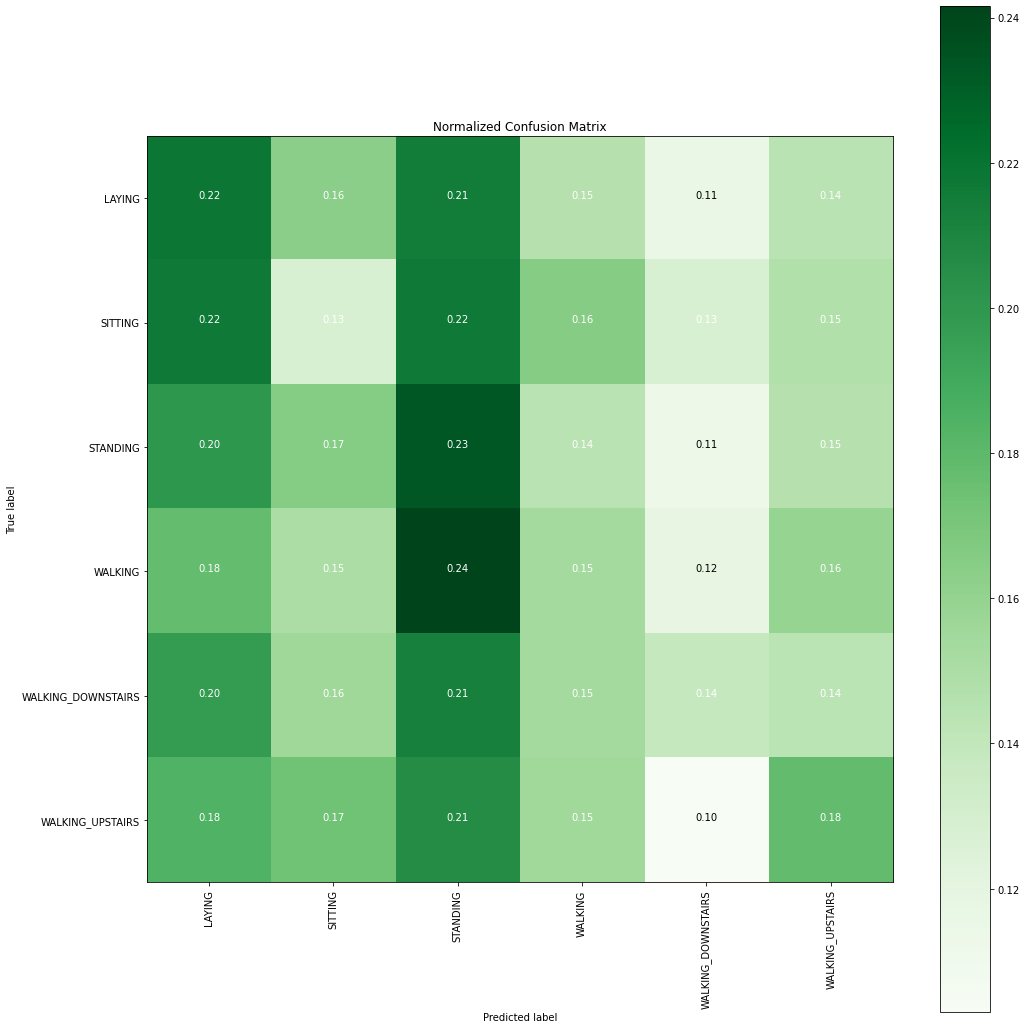


 F1 Score:0.17328207288993078


==> Best Estimator:
	LogisticRegression(C=0.01, random_state=0)


==> Best parameters:
	Parameters of best estimator : {'C': 0.01, 'penalty': 'l2'}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.17217391304347823
As epsilon = 0.05
training the model...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Done
==> training time:- 0:00:46.339014

Predicting test data
==> testing time:- 0:00:00.015674

==> Accuracy:- 0.19123271550456017


 ********Confusion Matrix********

 [[154 124 127 111  61  84]
 [122 122 133  96  83  63]
 [ 93  97 151 106  67  91]
 [ 99  93 130  99  80  91]
 [ 82  91  79  95  48  61]
 [ 81  81  81  84  63  76]]


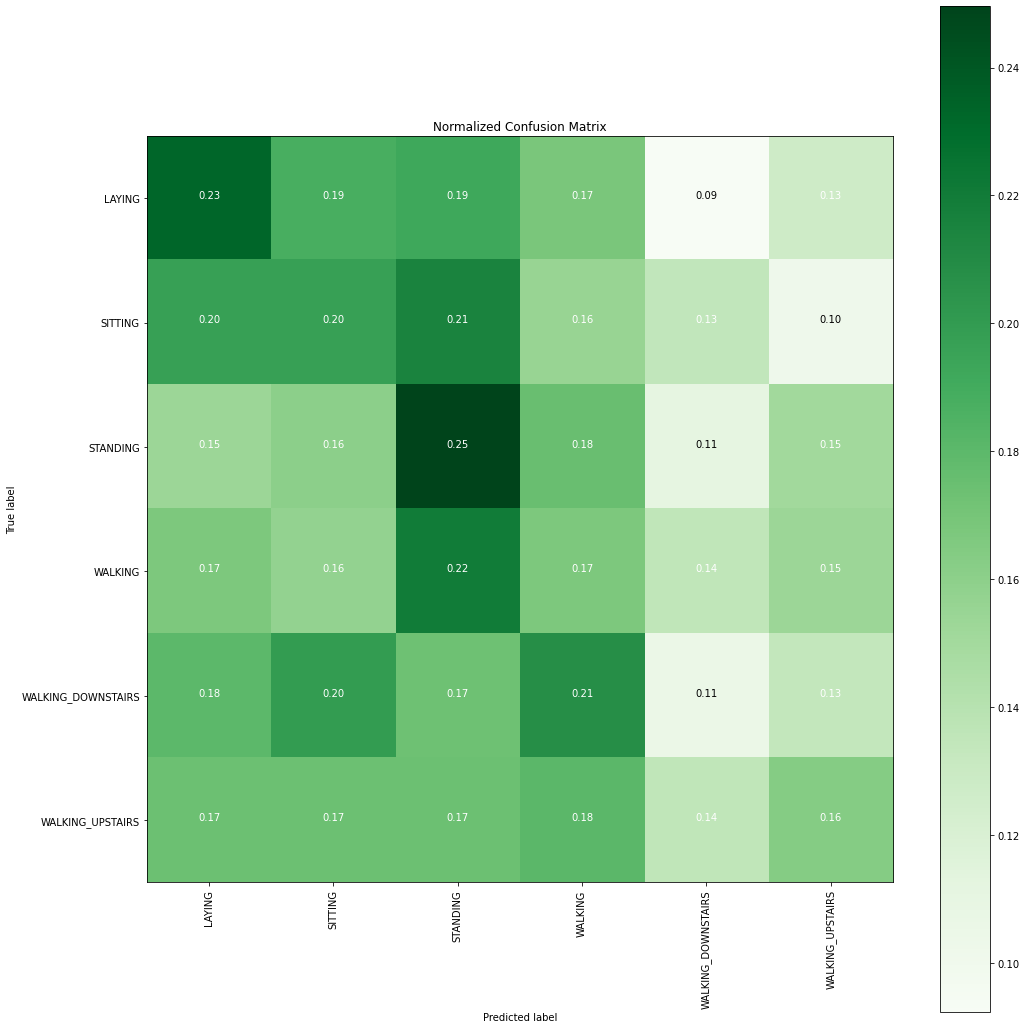


 F1 Score:0.18513980974431962


==> Best Estimator:
	LogisticRegression(C=0.01, random_state=0)


==> Best parameters:
	Parameters of best estimator : {'C': 0.01, 'penalty': 'l2'}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.18289855072463768
As epsilon = 0.1
training the model...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Done
==> training time:- 0:01:00.385613

Predicting test data
==> testing time:- 0:00:00.013231

==> Accuracy:- 0.2191821123859959


 ********Confusion Matrix********

 [[167 120 159  73  56  86]
 [140 110 138  87  57  87]
 [136  81 164  72  68  84]
 [ 96  73  98 106  98 121]
 [ 62  56  62  95  94  87]
 [ 81  54  90  77  60 104]]


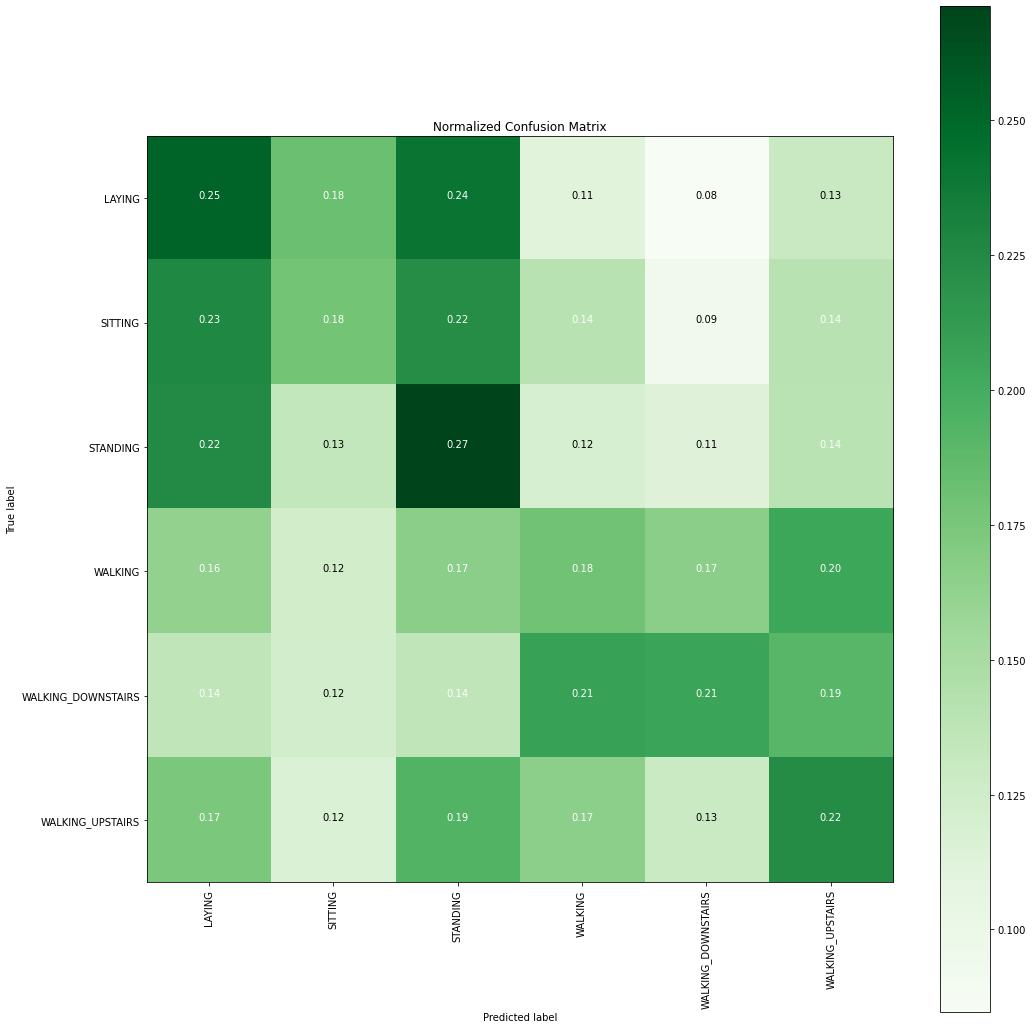


 F1 Score:0.21673638080077606


==> Best Estimator:
	LogisticRegression(C=0.01, random_state=0)


==> Best parameters:
	Parameters of best estimator : {'C': 0.01, 'penalty': 'l2'}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.2218840579710145
As epsilon = 0.3
training the model...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Done
==> training time:- 0:01:48.140152

Predicting test data
==> testing time:- 0:00:00.017671

==> Accuracy:- 0.3545160341276846


 ********Confusion Matrix********

 [[310 139 138  23  19  32]
 [164 172 191  39  15  38]
 [117 166 219  53  15  35]
 [ 32  35  51 197 138 139]
 [ 20  17  21 114 171 113]
 [ 36  28  43 109 114 136]]


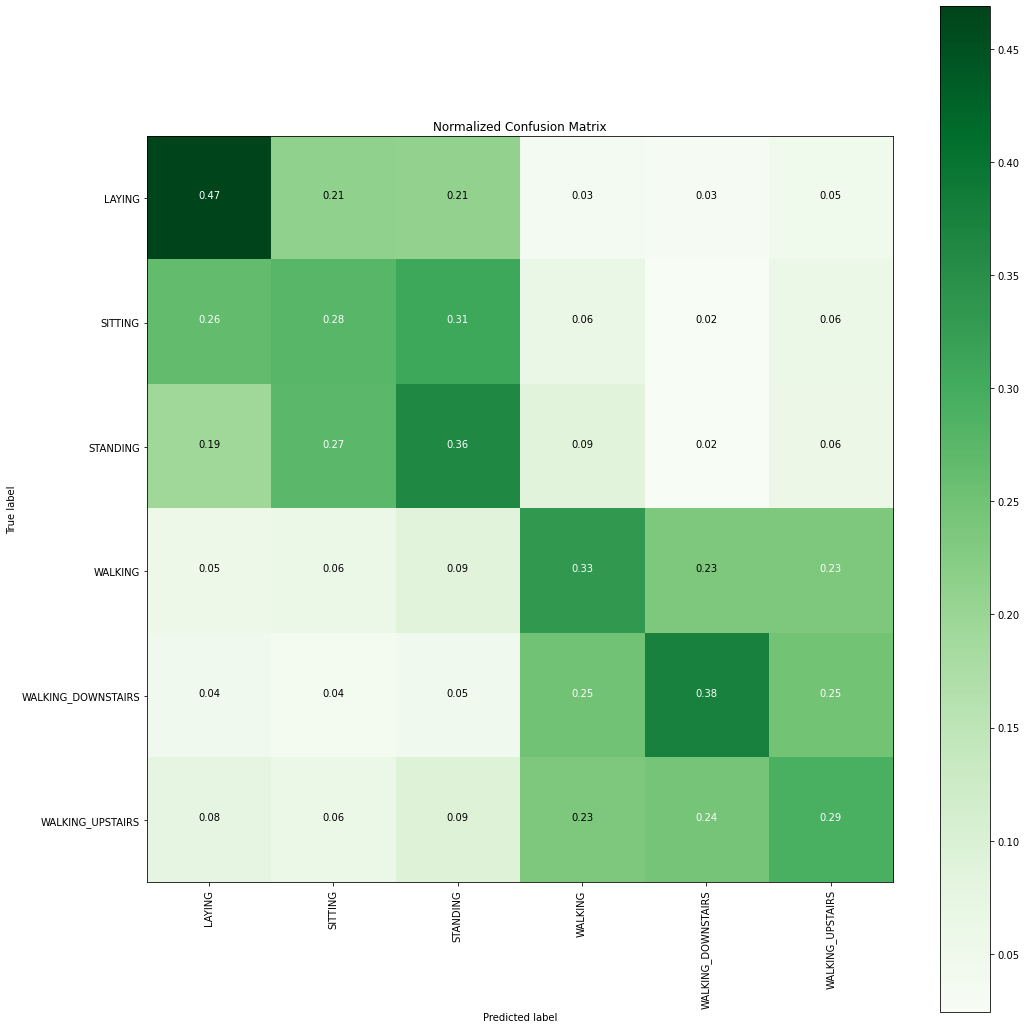


 F1 Score:0.3503989023436182


==> Best Estimator:
	LogisticRegression(C=0.1, random_state=0)


==> Best parameters:
	Parameters of best estimator : {'C': 0.1, 'penalty': 'l2'}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.33710144927536234
As epsilon = 0.5
training the model...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Done
==> training time:- 0:01:40.502415

Predicting test data
==> testing time:- 0:00:00.075035

==> Accuracy:- 0.4592527213886437


 ********Confusion Matrix********

 [[403  96 130  10   5  17]
 [146 213 227  15   2  16]
 [101 164 303  10   2  25]
 [ 20  18  27 241 151 135]
 [  9   4   6 142 199  96]
 [ 10  11  15 132  96 202]]


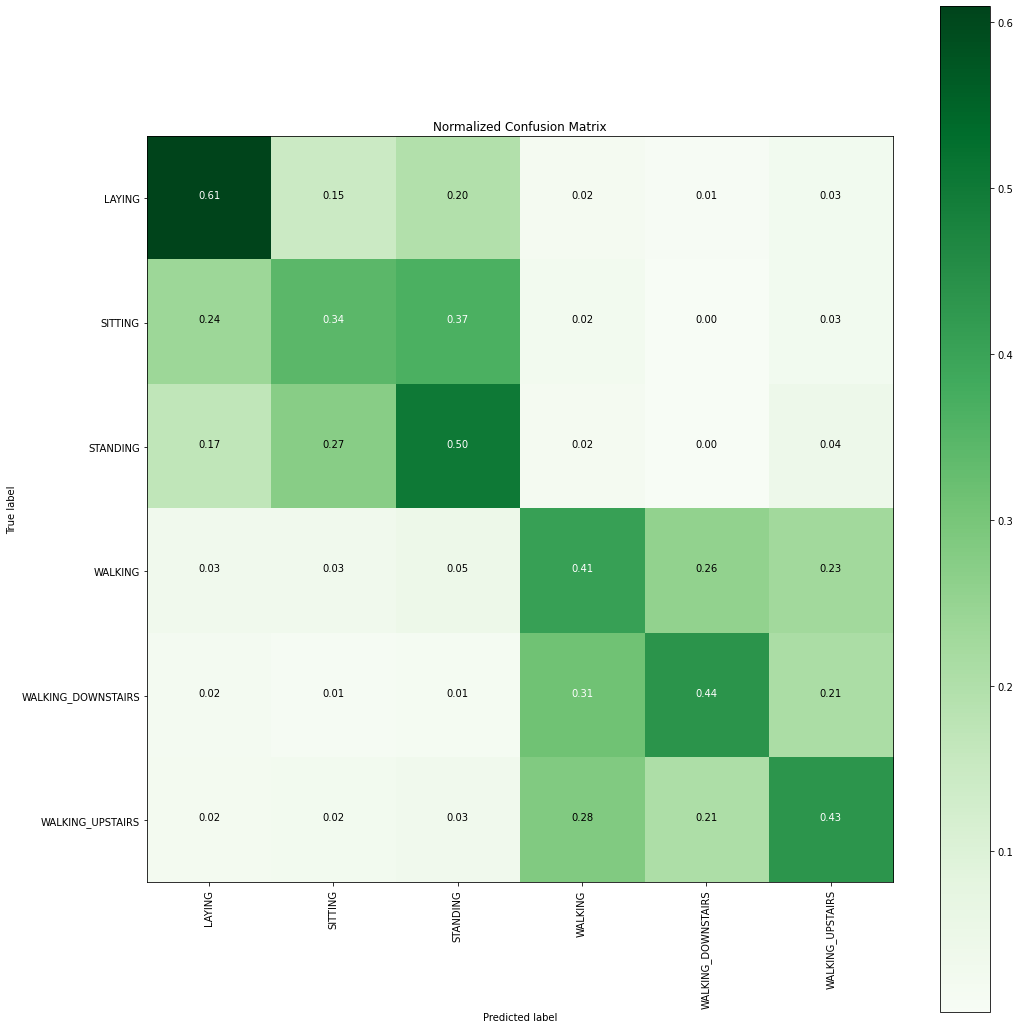


 F1 Score:0.45305730364837077


==> Best Estimator:
	LogisticRegression(C=0.01, random_state=0)


==> Best parameters:
	Parameters of best estimator : {'C': 0.01, 'penalty': 'l2'}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.44710144927536233
As epsilon = 1.0
training the model...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Done
==> training time:- 0:01:35.269154

Predicting test data
==> testing time:- 0:00:00.011269

==> Accuracy:- 0.6322447778758459


 ********Confusion Matrix********

 [[555  63  37   0   0   6]
 [ 71 311 222   3   0  12]
 [ 44 179 370   4   0   8]
 [  2   3   8 338 128 113]
 [  0   0   1  84 286  85]
 [  1   4   2 111  59 289]]


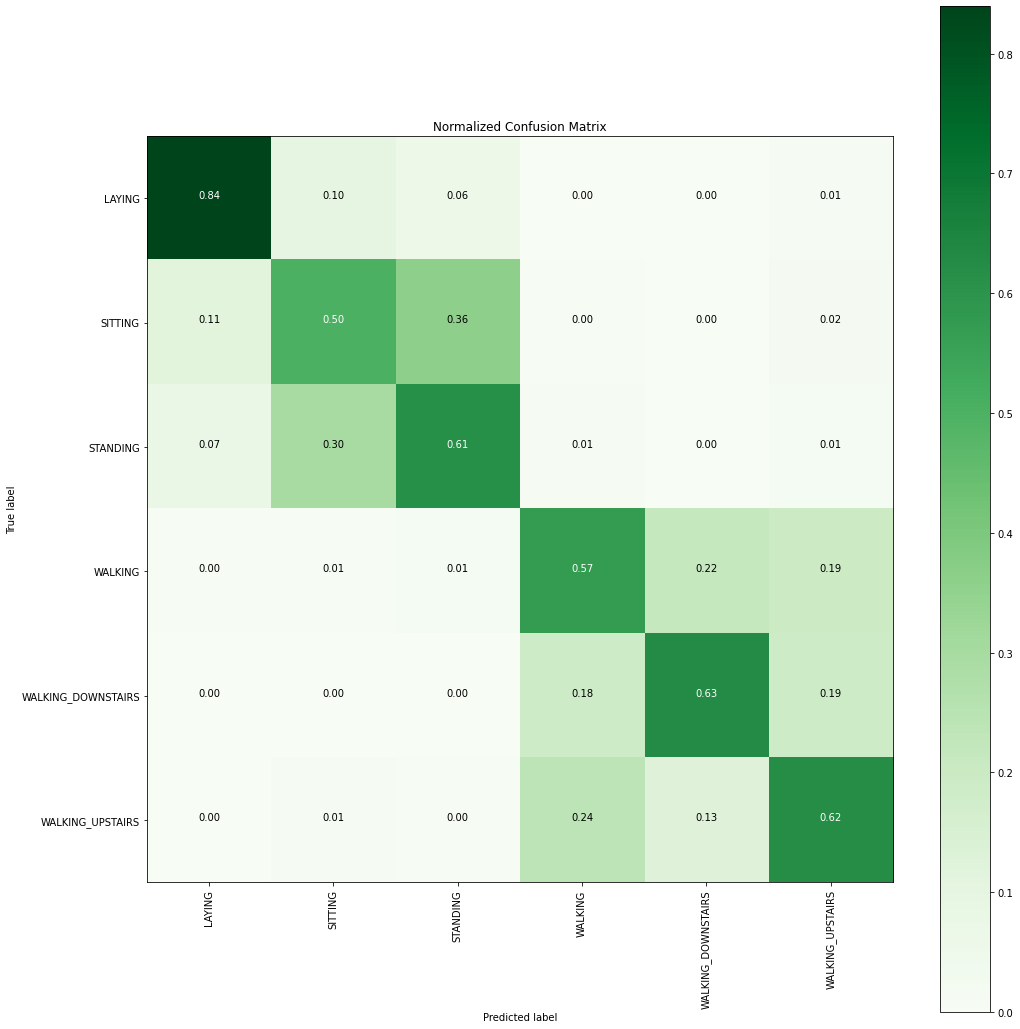


 F1 Score:0.6262190892925726


==> Best Estimator:
	LogisticRegression(C=0.01, random_state=0)


==> Best parameters:
	Parameters of best estimator : {'C': 0.01, 'penalty': 'l2'}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.6107246376811594
As epsilon = 1.5
training the model...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Done
==> training time:- 0:01:33.238758

Predicting test data
==> testing time:- 0:00:00.032989

==> Accuracy:- 0.7396293027360988


 ********Confusion Matrix********

 [[614  34  11   1   0   1]
 [ 36 358 216   0   0   9]
 [  6 175 421   3   0   0]
 [  1   1   2 438  82  68]
 [  0   1   1  64 335  55]
 [  0   0   2  68  48 348]]


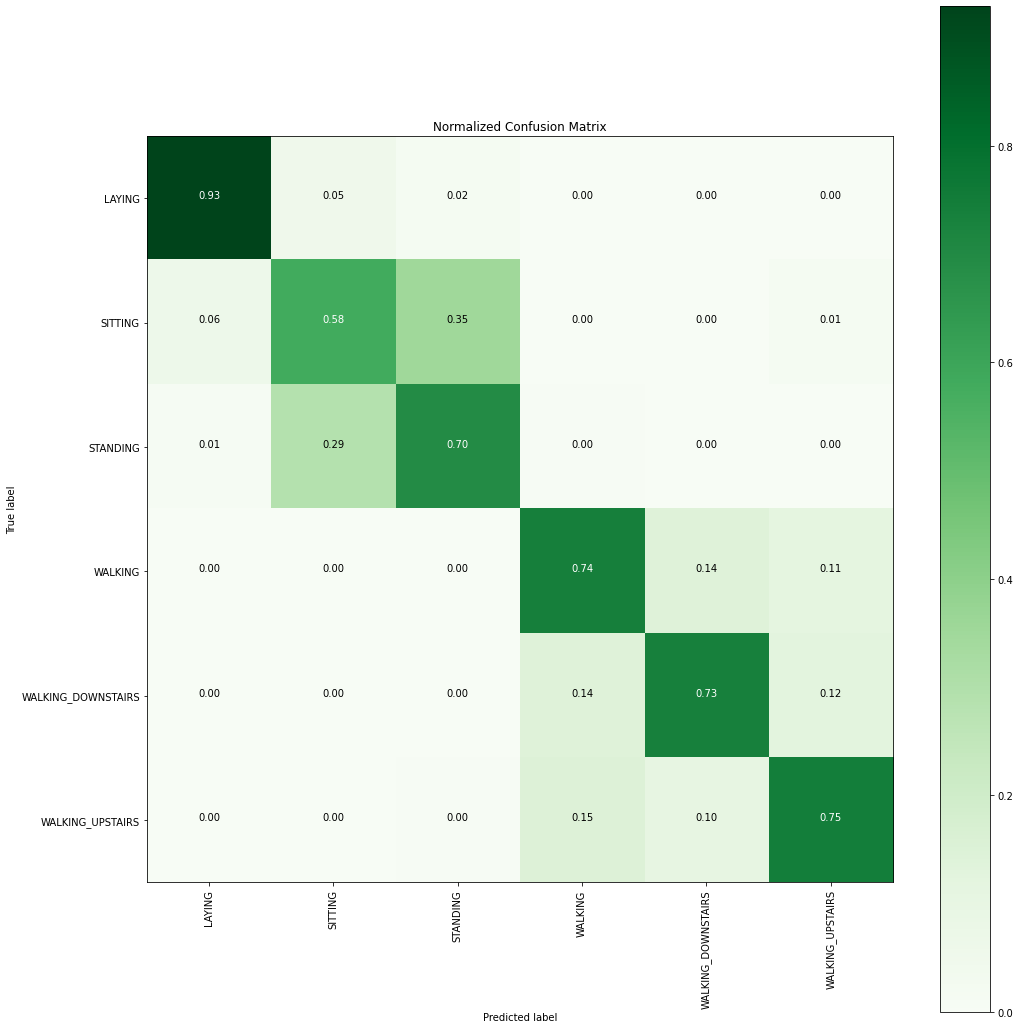


 F1 Score:0.7362389615391876


==> Best Estimator:
	LogisticRegression(C=0.01, random_state=0)


==> Best parameters:
	Parameters of best estimator : {'C': 0.01, 'penalty': 'l2'}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.7271014492753624
As epsilon = 2.0
training the model...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Done
==> training time:- 0:01:40.412216

Predicting test data
==> testing time:- 0:00:00.039580

==> Accuracy:- 0.8105325095616358


 ********Confusion Matrix********

 [[647   8   5   1   0   0]
 [ 19 400 195   0   0   5]
 [  3 137 462   1   0   2]
 [  0   0   0 502  38  52]
 [  0   0   1  42 364  49]
 [  0   1   0  54  31 380]]


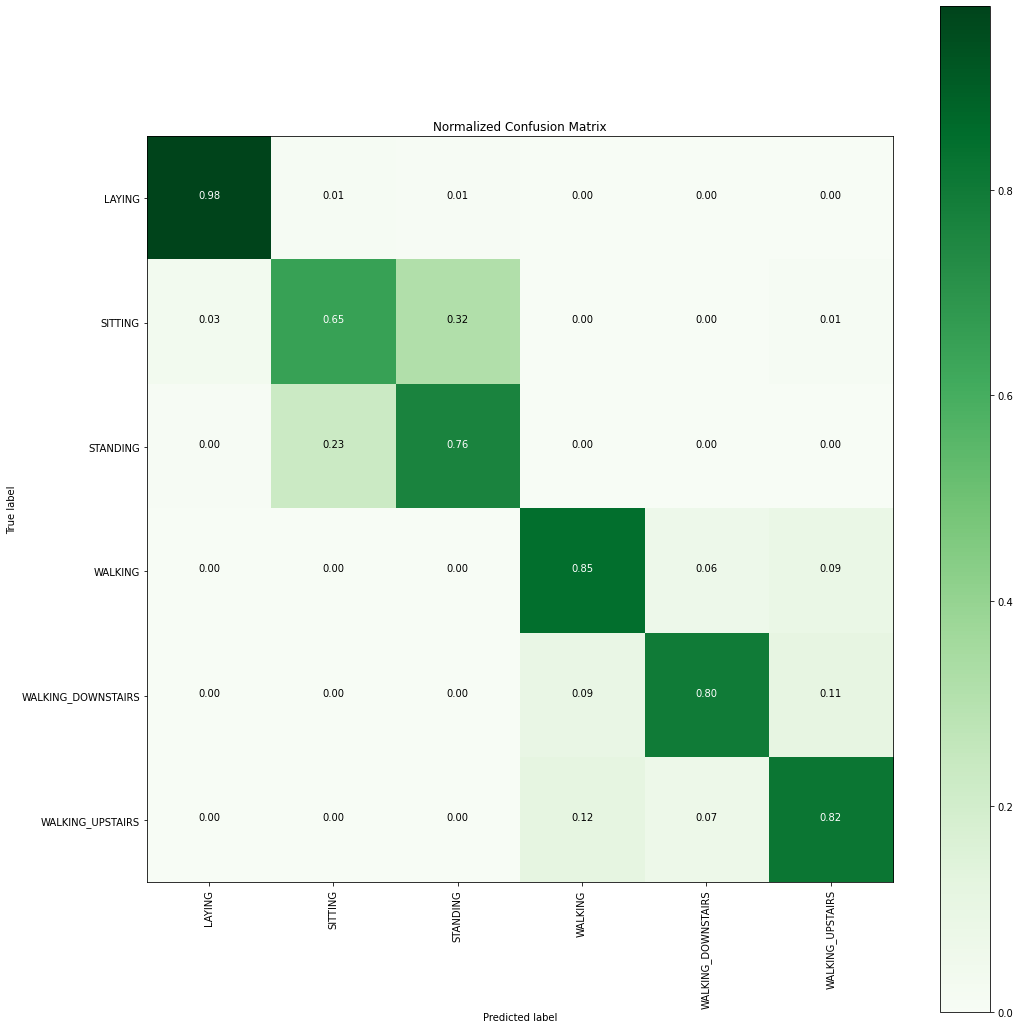


 F1 Score:0.8076932422831149


==> Best Estimator:
	LogisticRegression(C=0.01, random_state=0)


==> Best parameters:
	Parameters of best estimator : {'C': 0.01, 'penalty': 'l2'}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.7981159420289854
As epsilon = 2.5
training the model...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Done
==> training time:- 0:01:32.677052

Predicting test data
==> testing time:- 0:00:00.016435

==> Accuracy:- 0.8481906443071492


 ********Confusion Matrix********

 [[653   6   1   0   0   1]
 [ 17 430 165   0   0   7]
 [  0 120 484   0   0   1]
 [  0   0   1 522  22  47]
 [  0   0   0  28 392  36]
 [  0   0   0  38  26 402]]


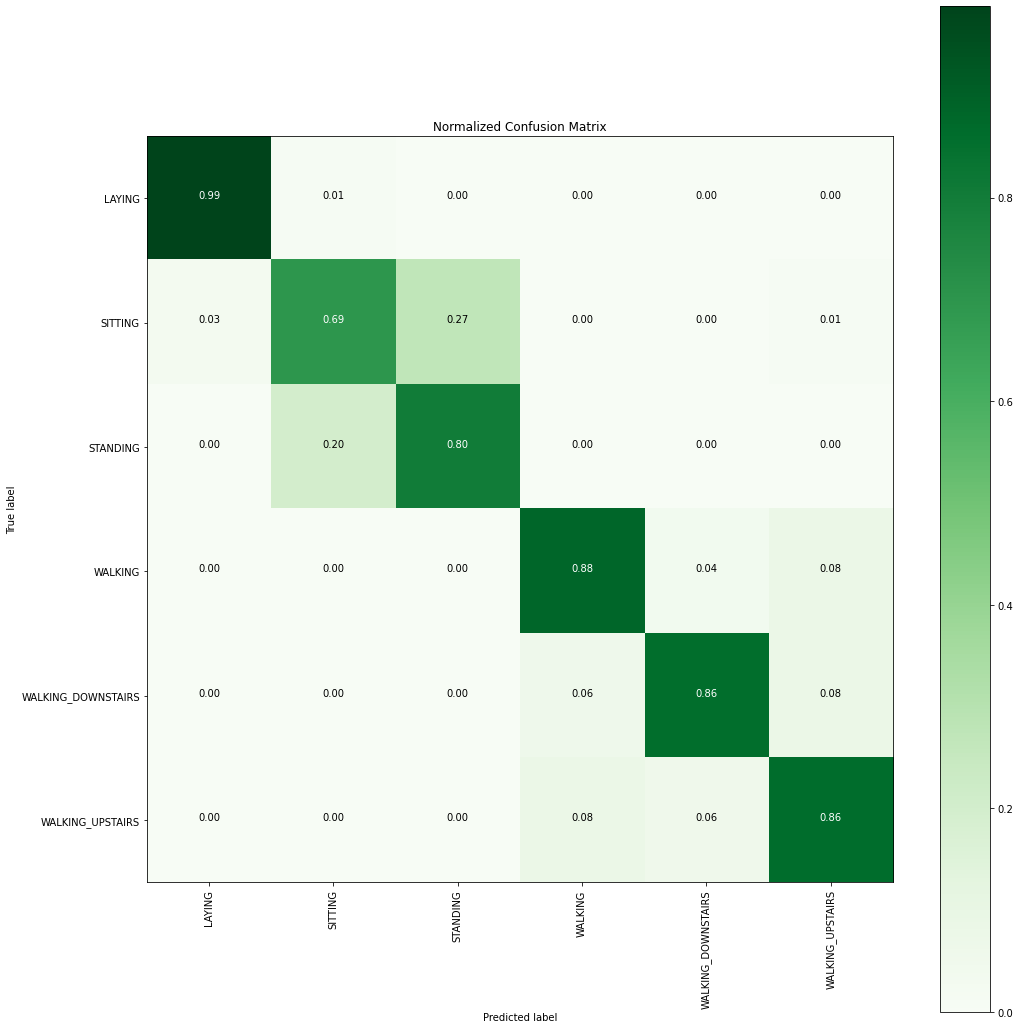


 F1 Score:0.8468464038748369


==> Best Estimator:
	LogisticRegression(C=0.01, random_state=0)


==> Best parameters:
	Parameters of best estimator : {'C': 0.01, 'penalty': 'l2'}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.8443478260869565
As epsilon = 3
training the model...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Done
==> training time:- 0:01:40.497821

Predicting test data
==> testing time:- 0:00:00.038511

==> Accuracy:- 0.8746690203000883


 ********Confusion Matrix********

 [[659   1   1   0   0   0]
 [ 19 446 149   0   0   5]
 [  0  96 508   0   0   1]
 [  0   0   0 537  21  34]
 [  0   0   0  23 394  39]
 [  0   0   0  20  17 429]]


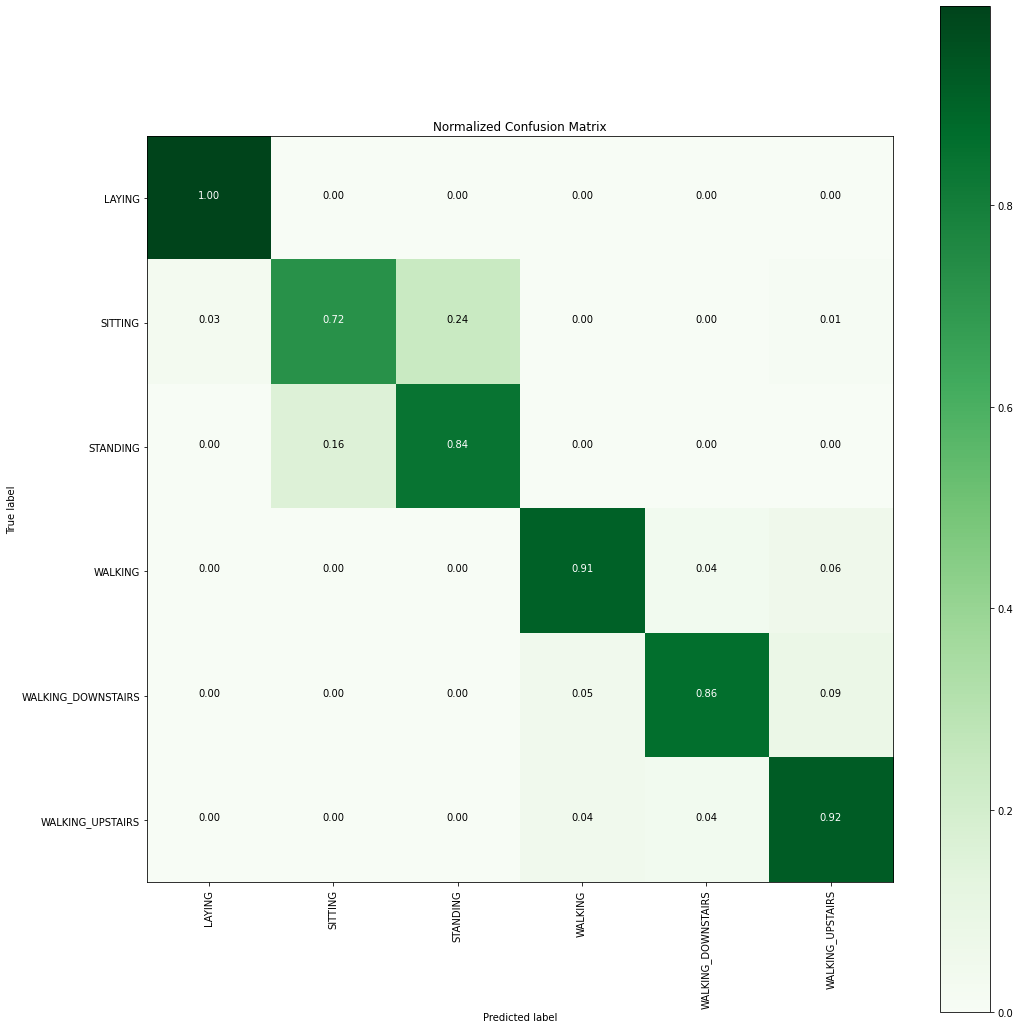


 F1 Score:0.873510944842229


==> Best Estimator:
	LogisticRegression(C=0.01, random_state=0)


==> Best parameters:
	Parameters of best estimator : {'C': 0.01, 'penalty': 'l2'}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.8746376811594203
As epsilon = 4
training the model...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Done
==> training time:- 0:01:43.498741

Predicting test data
==> testing time:- 0:00:00.043560

==> Accuracy:- 0.8937922918505443


 ********Confusion Matrix********

 [[658   3   0   0   0   0]
 [  9 467 139   0   0   4]
 [  0  88 517   0   0   0]
 [  0   0   0 561  16  15]
 [  0   0   0  16 407  33]
 [  0   0   0  20  18 428]]


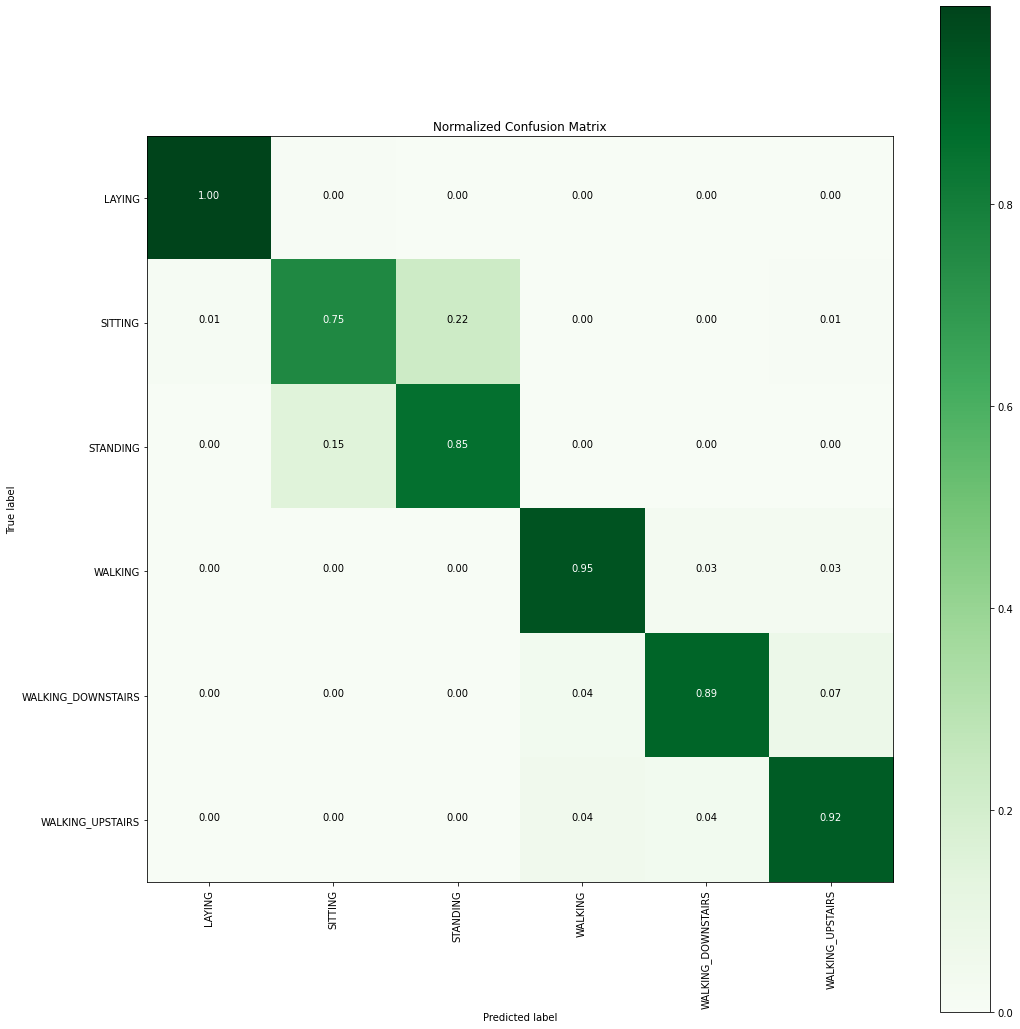


 F1 Score:0.8934121580625772


==> Best Estimator:
	LogisticRegression(C=0.01, random_state=0)


==> Best parameters:
	Parameters of best estimator : {'C': 0.01, 'penalty': 'l2'}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.9001449275362319
As epsilon = 5
training the model...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Done
==> training time:- 0:01:26.226202

Predicting test data
==> testing time:- 0:00:00.017838

==> Accuracy:- 0.9176228302441894


 ********Confusion Matrix********

 [[661   0   0   0   0   0]
 [  5 501 109   0   0   4]
 [  0  81 524   0   0   0]
 [  0   0   0 571   4  17]
 [  0   0   0  15 419  22]
 [  0   0   0  11  12 443]]


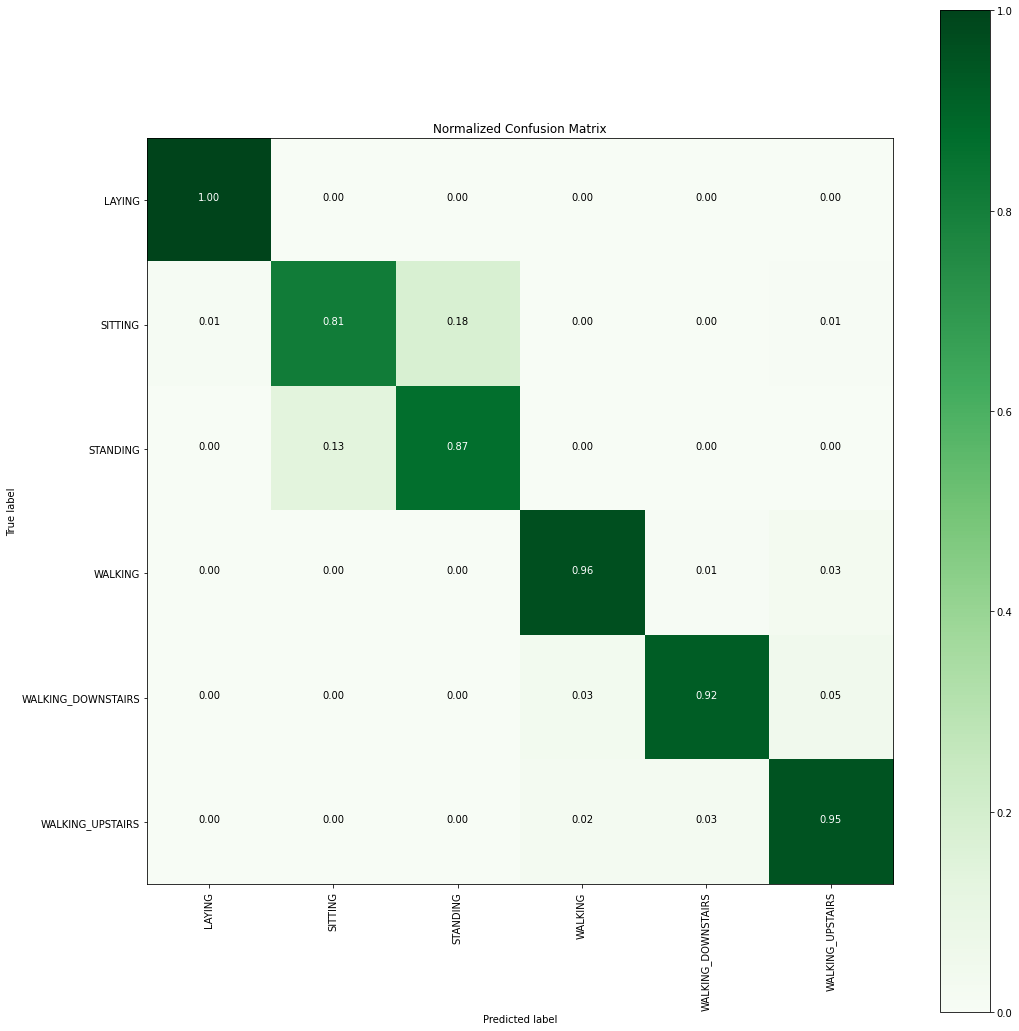


 F1 Score:0.9181205052009562


==> Best Estimator:
	LogisticRegression(C=0.01, random_state=0)


==> Best parameters:
	Parameters of best estimator : {'C': 0.01, 'penalty': 'l2'}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.9182608695652175


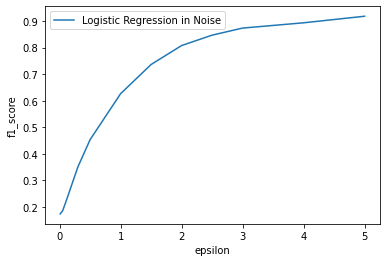

In [24]:
# precision = 0.1  # precision: 精度
# limit_x = 5
# linspace: num (個)の等差数列を作成
# epsilons = np.linspace(1, 5, num=int(limit_x/precision))
epsilons = [0.01, 0.05, 0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 2.5, 3, 4, 5]
f1_array_lr = []


for epsilon in epsilons:
    # epsilon = 0.1
    # default sensitivity = 1.0

    X_train_noise = X_train.copy()
    X_test_noise = X_test.copy()

    X_train_noise_array = X_train_noise.values
    X_test_noise_array = X_test_noise.values

    for i in range(len(X_train_noise_array)):
        X_train_noise_array[i] = X_train_noise_array[i] + np.random.laplace(0, 1.0/epsilon, X_train_noise_array[i].shape)
    for j in range(len(X_test_noise_array)):
        X_test_noise_array[j] = X_test_noise_array[j] + np.random.laplace(0, 1.0/epsilon, X_test_noise_array[j].shape)


    # start Grid search
    # C: 正則化項の係数（正則化の強さの逆数）
    # penalty: 正則化をL1ノルムでやるかL2ノルムでやるかを，l1 または l2 から選択
    param_grid = [{
        'C': [0.01, 0.1, 1, 10, 20, 30],
        'penalty': ['l2', 'l1']
    }]
    log_reg = linear_model.LogisticRegression(random_state=0)
    log_reg_grid = GridSearchCV(log_reg, param_grid=param_grid, cv=5, verbose=1, n_jobs=1)
    print("As epsilon = {}".format(epsilon))
    log_reg_grid_results, f1 = perform_model_epsilon(log_reg_grid, X_train_noise_array, y_train, X_test_noise_array, y_test, class_labels=labels)
    
    f1_array_lr.append(f1)
    # observe the attributes of the model
    print_grid_search_attributes(log_reg_grid_results['model'])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(epsilons, f1_array_lr, label='Logistic Regression in Noise')
ax.set_xlabel('epsilon')
ax.set_ylabel('f1_score')
plt.legend(loc='best')
plt.show()


## 3. Kernel SVM with GridSearch
ガウスカーネル
𝐾(𝑥𝑖,𝑥𝑗)=exp(−𝛾||𝑥𝑖–𝑥𝑗||2)

training the model...
Done
==> training time:- 0:04:09.598501

Predicting test data
==> testing time:- 0:00:02.223328

==> Accuracy:- 0.9626739056667798


 ********Confusion Matrix********

 [[537   0   0   0   0   0]
 [  0 441  48   0   0   2]
 [  0  12 520   0   0   0]
 [  0   0   0 489   2   5]
 [  0   0   0   4 397  19]
 [  0   0   0  17   1 453]]


/var/folders/st/dmkj3b756jq20y6qwzjf_twc0000gn/T/ipykernel_58509/1434089209.py:42: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=False) # グリッドを非表示


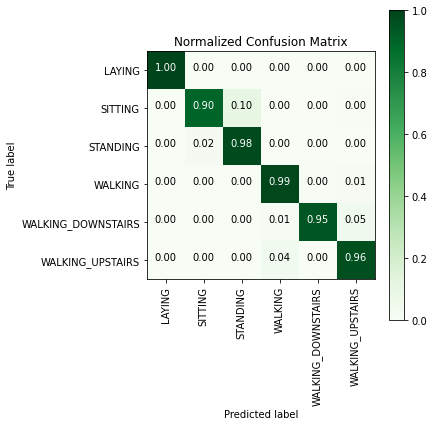

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.97      0.90      0.93       491
          STANDING       0.92      0.98      0.95       532
           WALKING       0.96      0.99      0.97       496
WALKING_DOWNSTAIRS       0.99      0.95      0.97       420
  WALKING_UPSTAIRS       0.95      0.96      0.95       471

          accuracy                           0.96      2947
         macro avg       0.96      0.96      0.96      2947
      weighted avg       0.96      0.96      0.96      2947



==> Best Estimator:
	SVC(C=16, gamma=0.0078125)


==> Best parameters:
	Parameters of best estimator : {'C': 16, 'gamma': 0.0078125}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.9447834551903698


In [13]:
# gamma: カーネル係数
# kernel: アルゴリズムで使用されるカーネルタイプを指定
parameters = {'C':[2,8,16],\
              'gamma': [ 0.0078125, 0.125, 2]}
rbf_svm = SVC(kernel='rbf')
rbf_svm_grid = GridSearchCV(rbf_svm,param_grid=parameters, n_jobs=-1)
rbf_svm_grid_results = perform_model(rbf_svm_grid, X_train, y_train, X_test, y_test, class_labels=labels)

# observe the attributes of the model 
print_grid_search_attributes(rbf_svm_grid_results['model'])

As epsilon = 1.5
training the model...
Done
==> training time:- 0:09:22.638844

Predicting test data
==> testing time:- 0:00:09.558187

==> Accuracy:- 0.5286732270105192


 ********Confusion Matrix********

 [[531   0   6   0   0   0]
 [ 95  25 371   0   0   0]
 [ 31   4 497   0   0   0]
 [  0   0   2 494   0   0]
 [  1   0   1 415   3   0]
 [  4   0   9 450   0   8]]


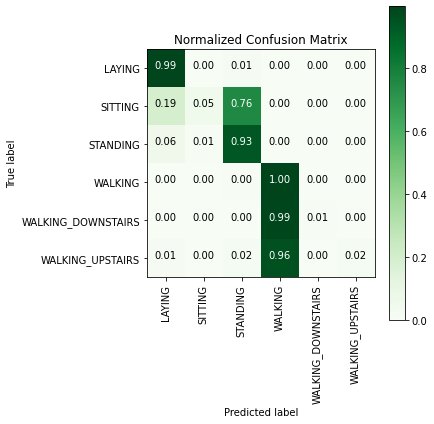

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.80      0.99      0.89       537
           SITTING       0.86      0.05      0.10       491
          STANDING       0.56      0.93      0.70       532
           WALKING       0.36      1.00      0.53       496
WALKING_DOWNSTAIRS       1.00      0.01      0.01       420
  WALKING_UPSTAIRS       1.00      0.02      0.03       471

          accuracy                           0.53      2947
         macro avg       0.76      0.50      0.38      2947
      weighted avg       0.75      0.53      0.40      2947



==> Best Estimator:
	SVC(C=2, gamma=0.0078125)


==> Best parameters:
	Parameters of best estimator : {'C': 2, 'gamma': 0.0078125}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.5331883072739634
As epsilon = 2
training the model...
Done
==>

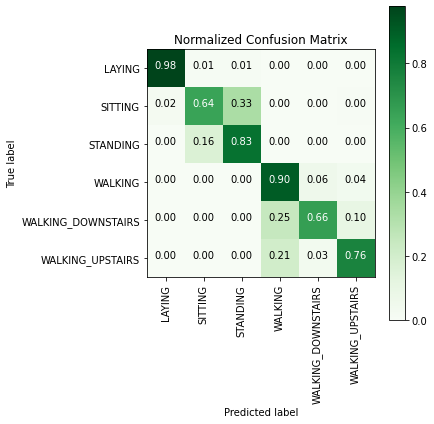

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.98      0.98      0.98       537
           SITTING       0.77      0.64      0.70       491
          STANDING       0.72      0.83      0.77       532
           WALKING       0.69      0.90      0.78       496
WALKING_DOWNSTAIRS       0.86      0.66      0.74       420
  WALKING_UPSTAIRS       0.85      0.76      0.80       471

          accuracy                           0.80      2947
         macro avg       0.81      0.79      0.80      2947
      weighted avg       0.81      0.80      0.80      2947



==> Best Estimator:
	SVC(C=2, gamma=0.0078125)


==> Best parameters:
	Parameters of best estimator : {'C': 2, 'gamma': 0.0078125}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.802505121695177
As epsilon = 2.5
training the model...
Done
==

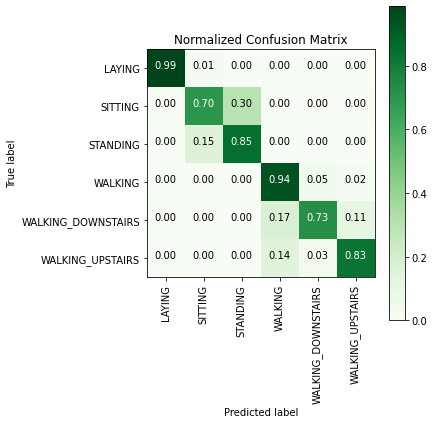

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      0.99      0.99       537
           SITTING       0.80      0.70      0.75       491
          STANDING       0.76      0.85      0.80       532
           WALKING       0.77      0.94      0.85       496
WALKING_DOWNSTAIRS       0.89      0.73      0.80       420
  WALKING_UPSTAIRS       0.87      0.83      0.85       471

          accuracy                           0.84      2947
         macro avg       0.85      0.84      0.84      2947
      weighted avg       0.85      0.84      0.84      2947



==> Best Estimator:
	SVC(C=8, gamma=0.0078125)


==> Best parameters:
	Parameters of best estimator : {'C': 8, 'gamma': 0.0078125}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.8318851075440374
As epsilon = 3
training the model...
Done
==>

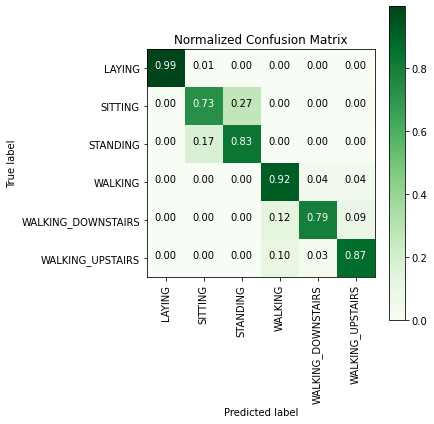

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      0.99      1.00       537
           SITTING       0.79      0.73      0.76       491
          STANDING       0.77      0.83      0.80       532
           WALKING       0.82      0.92      0.87       496
WALKING_DOWNSTAIRS       0.91      0.79      0.85       420
  WALKING_UPSTAIRS       0.88      0.87      0.87       471

          accuracy                           0.86      2947
         macro avg       0.86      0.85      0.86      2947
      weighted avg       0.86      0.86      0.86      2947



==> Best Estimator:
	SVC(C=2, gamma=0.0078125)


==> Best parameters:
	Parameters of best estimator : {'C': 2, 'gamma': 0.0078125}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.858410262813487
As epsilon = 4
training the model...
Done
==> 

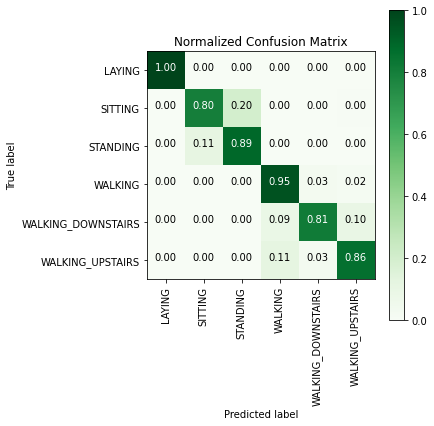

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.87      0.80      0.83       491
          STANDING       0.83      0.89      0.86       532
           WALKING       0.84      0.95      0.89       496
WALKING_DOWNSTAIRS       0.92      0.81      0.87       420
  WALKING_UPSTAIRS       0.89      0.86      0.87       471

          accuracy                           0.89      2947
         macro avg       0.89      0.89      0.89      2947
      weighted avg       0.89      0.89      0.89      2947



==> Best Estimator:
	SVC(C=2, gamma=0.0078125)


==> Best parameters:
	Parameters of best estimator : {'C': 2, 'gamma': 0.0078125}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.8705167015820605
As epsilon = 5
training the model...
Done
==>

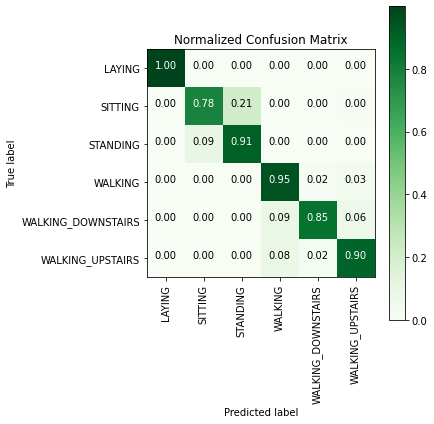

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.88      0.78      0.83       491
          STANDING       0.82      0.91      0.86       532
           WALKING       0.86      0.95      0.90       496
WALKING_DOWNSTAIRS       0.95      0.85      0.90       420
  WALKING_UPSTAIRS       0.90      0.90      0.90       471

          accuracy                           0.90      2947
         macro avg       0.90      0.90      0.90      2947
      weighted avg       0.90      0.90      0.90      2947



==> Best Estimator:
	SVC(C=2, gamma=0.0078125)


==> Best parameters:
	Parameters of best estimator : {'C': 2, 'gamma': 0.0078125}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.8936406812895111


In [14]:
import warnings
# 収束しなかった場合のwarning
from sklearn.exceptions import ConvergenceWarning
# warningを無視する
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

epsilons = [1.5, 2, 2.5, 3, 4, 5]


for epsilon in epsilons:
    # epsilon = 0.1
    # default sensitivity = 1.0
    
    print("As epsilon = {}".format(epsilon))

    X_train_noise = X_train.copy()
    X_test_noise = X_test.copy()

    X_train_noise_array = X_train_noise.values
    X_test_noise_array = X_test_noise.values

    for i in range(len(X_train_noise_array)):
        X_train_noise_array[i] = X_train_noise_array[i] + np.random.laplace(0, 1.0/epsilon, X_train_noise_array[i].shape)
    for j in range(len(X_test_noise_array)):
        X_test_noise_array[j] = X_test_noise_array[j] + np.random.laplace(0, 1.0/epsilon, X_test_noise_array[j].shape)
        
    
    # gamma: カーネル係数
    # kernel: ルゴリズムで使用されるカーネルタイプを指定
    parameters = {'C':[2,8,16],\
                'gamma': [ 0.0078125, 0.125, 2]}
    # カーネル関数： rbf = ガウスカーネル
    rbf_svm = SVC(kernel='rbf')
    rbf_svm_grid = GridSearchCV(rbf_svm, param_grid=parameters, n_jobs=-1)
    rbf_svm_grid_results = perform_model(rbf_svm_grid, X_train_noise_array, y_train, X_test_noise_array, y_test, class_labels=labels)

    # observe the attributes of the model 
    print_grid_search_attributes(rbf_svm_grid_results['model'])


## 4. LightGBM with GridSearchCV

## 5. Random Forest Classifier with GridSearch

training the model...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Done
==> training time:- 0:12:17.505987

Predicting test data
==> testing time:- 0:00:00.178066

==> Accuracy:- 0.9723448072962636


 ********Confusion Matrix********

 [[661   0   0   0   0   0]
 [  0 583  35   0   0   1]
 [  0  27 578   0   0   0]
 [  0   0   0 584   3   5]
 [  0   0   0   4 439  13]
 [  0   0   0   1   5 460]]


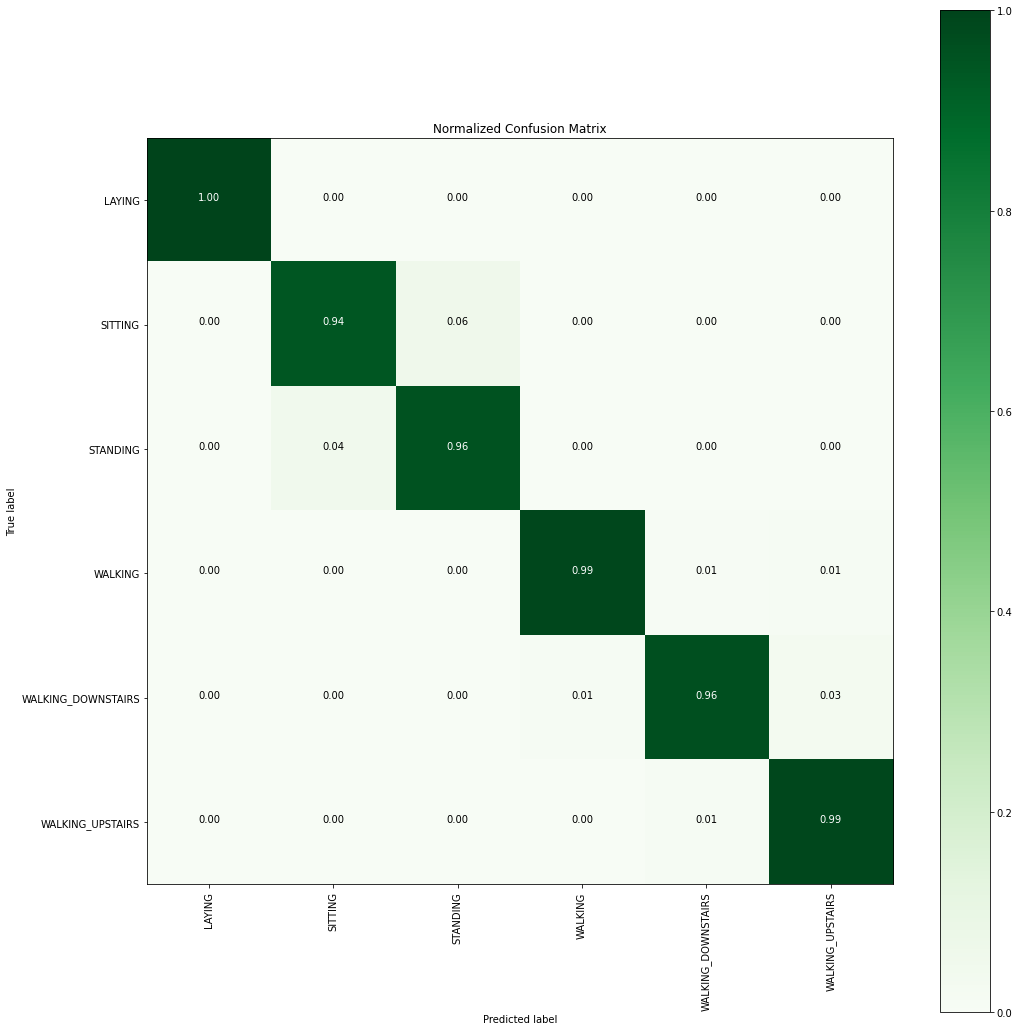


 F1 Score:0.9721145920427364


==> Best Estimator:
	RandomForestClassifier(max_depth=13, n_estimators=130)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 13, 'n_estimators': 130}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.9715942028985507


In [27]:
params = {'n_estimators': np.arange(10,201,20), 'max_depth':np.arange(3,15,2)}
rfc = RandomForestClassifier()
rfc_grid = GridSearchCV(rfc, param_grid=params, cv=5, verbose=1, n_jobs=-1)
rfc_grid_results, f1 = perform_model_epsilon(rfc_grid, X_train, y_train, X_test, y_test, class_labels=labels)

# observe the attributes of the model 
print_grid_search_attributes(rfc_grid_results['model'])

As epsilon = 0.01
training the model...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Done
==> training time:- 0:26:29.610667

Predicting test data
==> testing time:- 0:00:00.549174

==> Accuracy:- 0.1853486319505737


 ********Confusion Matrix********

 [[226   6 427   1   0   1]
 [216   8 393   1   0   1]
 [206   3 395   0   0   1]
 [213   6 372   1   0   0]
 [173   3 278   2   0   0]
 [172   3 289   2   0   0]]


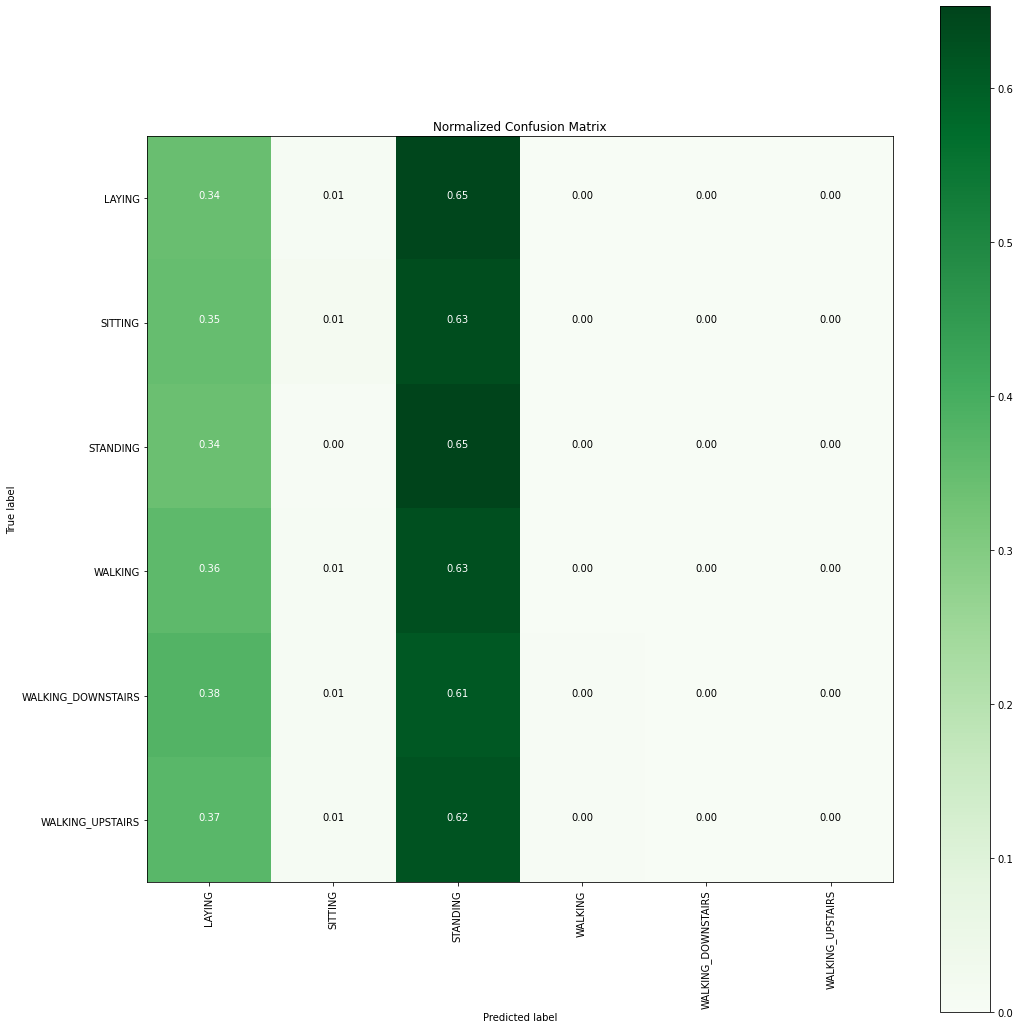


 F1 Score:0.09274425168438044


==> Best Estimator:
	RandomForestClassifier(max_depth=5, n_estimators=110)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 5, 'n_estimators': 110}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.18985507246376812
As epsilon = 0.05
training the model...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Done
==> training time:- 0:24:42.004021

Predicting test data
==> testing time:- 0:00:00.716039

==> Accuracy:- 0.18211238599588114


 ********Confusion Matrix********

 [[256  59 275  42   0  29]
 [220  69 264  48   2  16]
 [233  66 248  36   1  21]
 [222  62 252  40   3  13]
 [169  52 182  39   0  14]
 [185  43 192  40   0   6]]


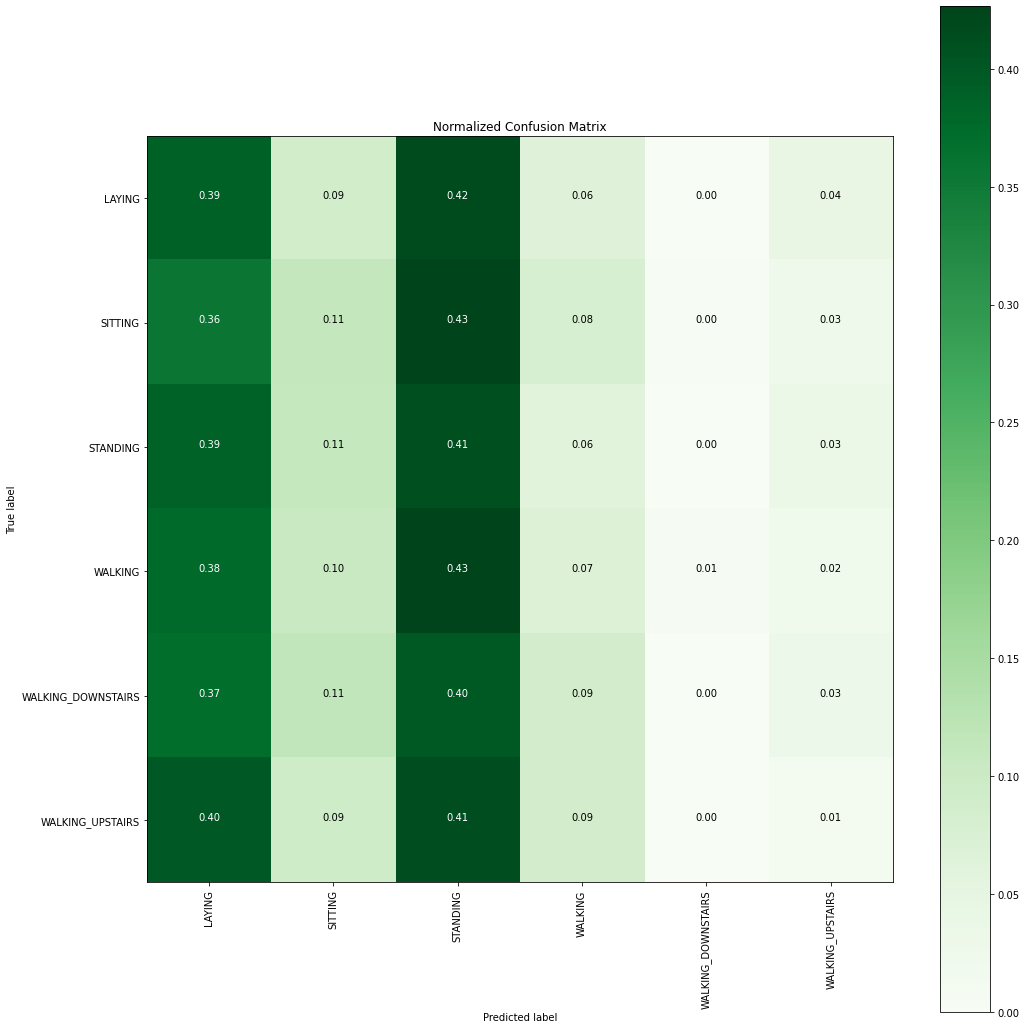


 F1 Score:0.12799635686685554


==> Best Estimator:
	RandomForestClassifier(max_depth=13, n_estimators=170)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 13, 'n_estimators': 170}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.19434782608695653
As epsilon = 0.1
training the model...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Done
==> training time:- 0:14:31.374322

Predicting test data
==> testing time:- 0:00:00.277936

==> Accuracy:- 0.20358929096793174


 ********Confusion Matrix********

 [[269   3 386   3   0   0]
 [216   2 397   4   0   0]
 [190   2 410   2   0   1]
 [207   4 368  10   0   3]
 [148   4 297   7   0   0]
 [158   3 299   5   0   1]]


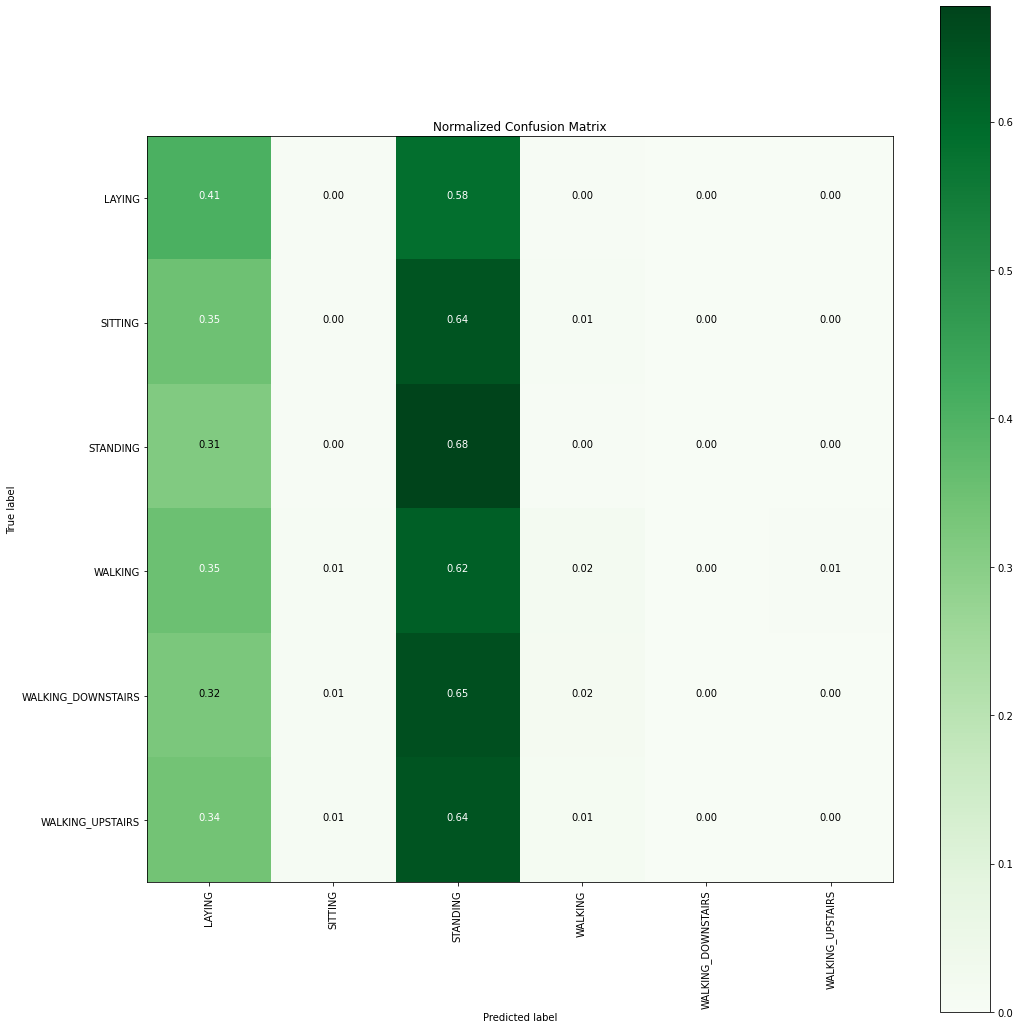


 F1 Score:0.10508047553480278


==> Best Estimator:
	RandomForestClassifier(max_depth=5, n_estimators=130)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 5, 'n_estimators': 130}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.20144927536231885
As epsilon = 0.3
training the model...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Done
==> training time:- 1:42:02.966235

Predicting test data
==> testing time:- 0:00:00.249892

==> Accuracy:- 0.3245072080023536


 ********Confusion Matrix********

 [[388  16 224  25   0   8]
 [216  24 353  22   0   4]
 [203  22 353  20   1   6]
 [105   7 135 263   5  77]
 [ 51   3  93 230   6  73]
 [ 82   7 107 198   3  69]]


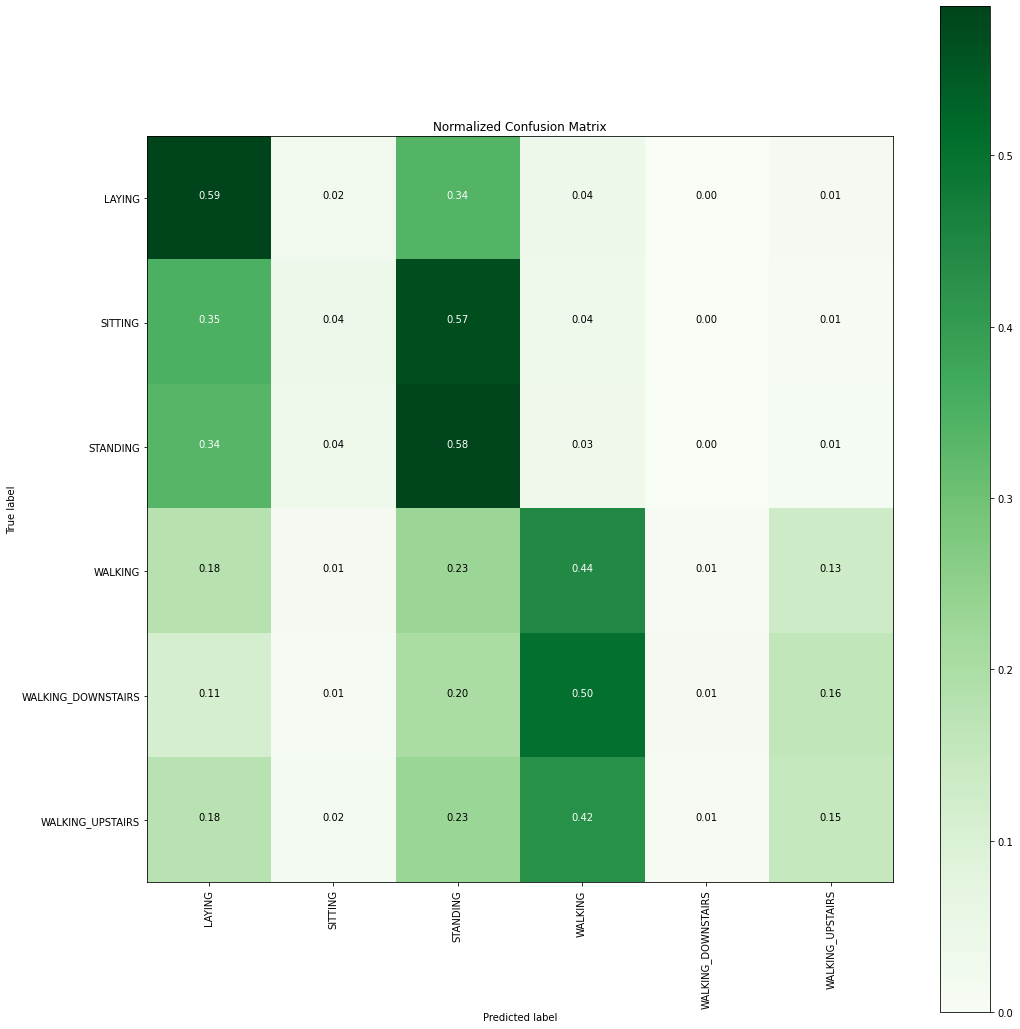


 F1 Score:0.2520970163885916


==> Best Estimator:
	RandomForestClassifier(max_depth=7, n_estimators=190)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 7, 'n_estimators': 190}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.32115942028985506
As epsilon = 0.5
training the model...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Done
==> training time:- 0:17:16.381077

Predicting test data
==> testing time:- 0:00:00.722263

==> Accuracy:- 0.42924389526331275


 ********Confusion Matrix********

 [[501  15 137   3   0   5]
 [186  73 347   9   0   4]
 [160  53 368  13   1  10]
 [ 27   6  47 343  46 123]
 [ 17   4  20 242  68 105]
 [ 32   4  51 233  40 106]]


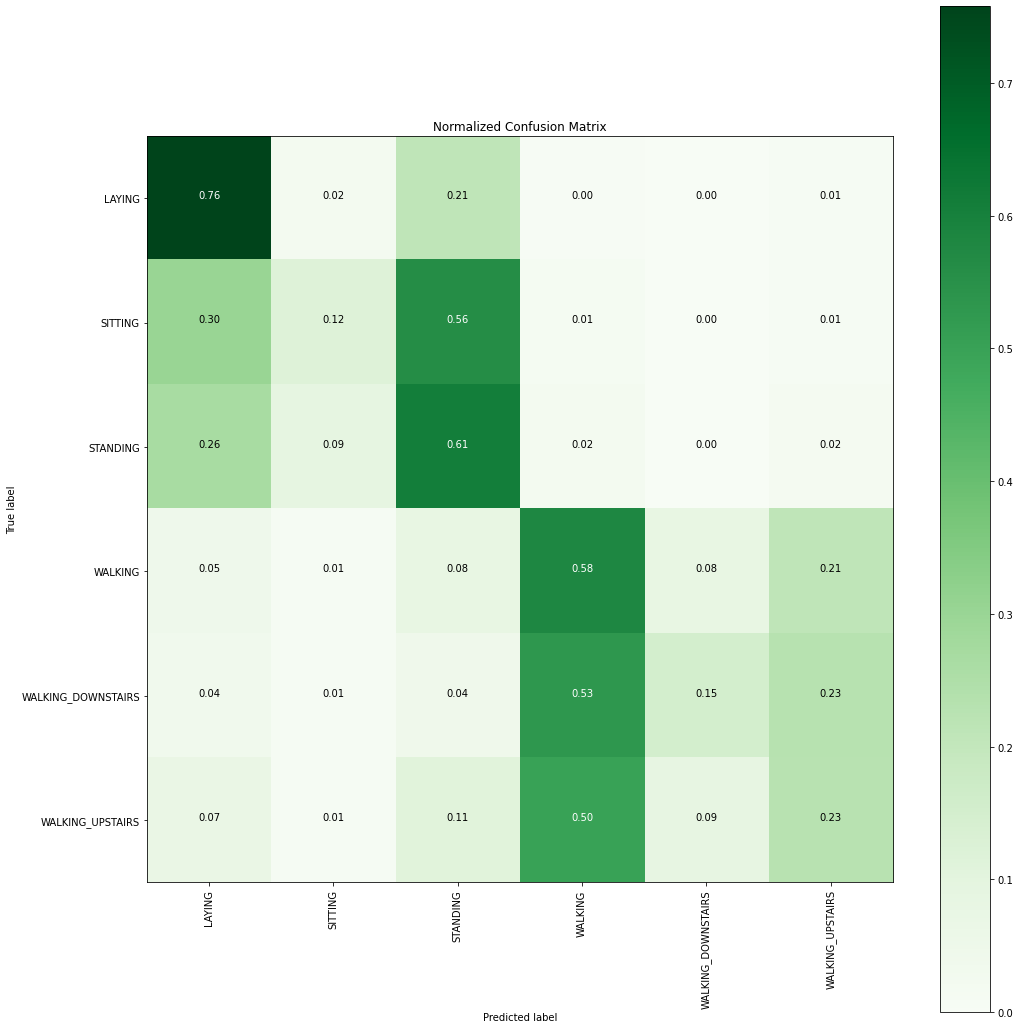


 F1 Score:0.37466579998117755


==> Best Estimator:
	RandomForestClassifier(max_depth=9, n_estimators=190)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 9, 'n_estimators': 190}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.43594202898550727
As epsilon = 1.0
training the model...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Done
==> training time:- 0:12:36.520224

Predicting test data
==> testing time:- 0:00:00.288769

==> Accuracy:- 0.6151809355692851


 ********Confusion Matrix********

 [[629   4  27   0   0   1]
 [ 97  87 427   5   0   3]
 [ 56  27 516   3   0   3]
 [  0   0   4 476  49  63]
 [  0   0   3 178 224  51]
 [  5   0   9 249  44 159]]


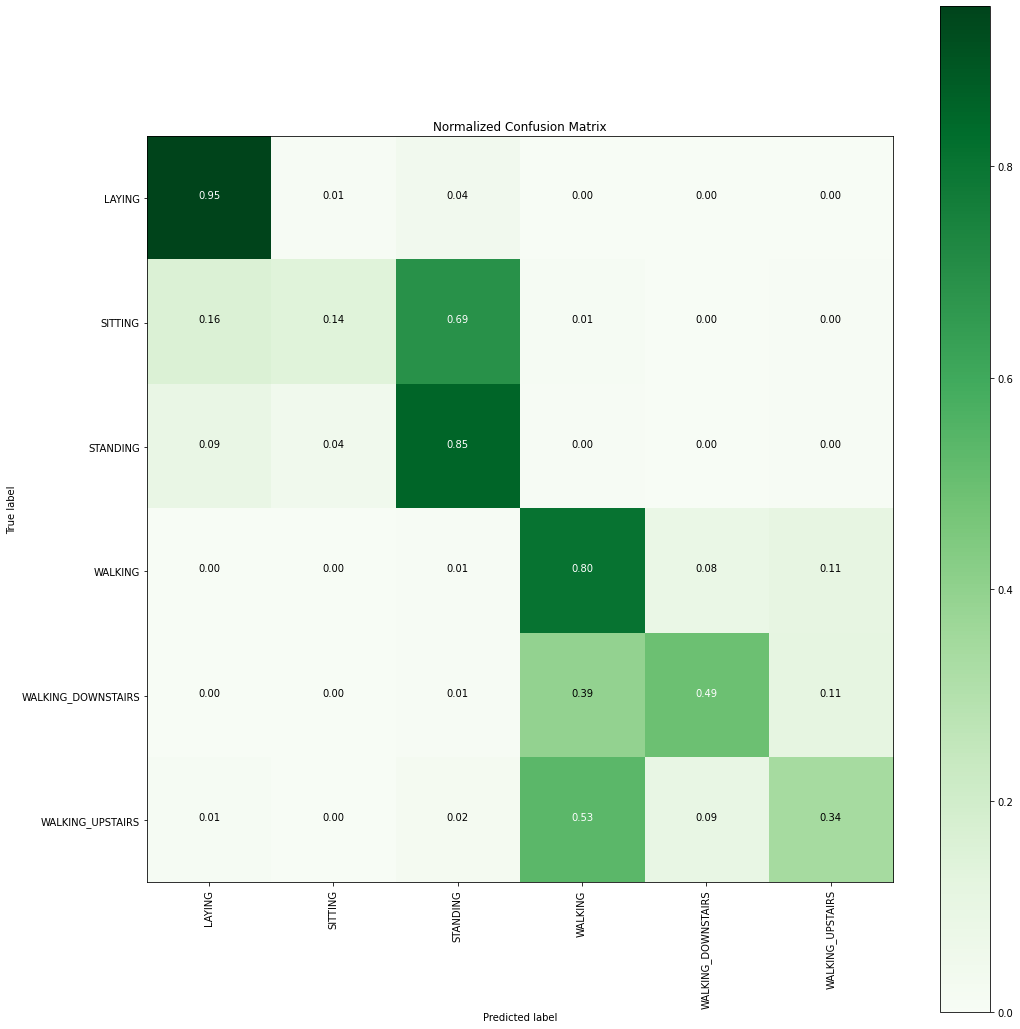


 F1 Score:0.565459820932595


==> Best Estimator:
	RandomForestClassifier(max_depth=7, n_estimators=190)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 7, 'n_estimators': 190}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.6101449275362318
As epsilon = 1.5
training the model...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Done
==> training time:- 0:07:36.338364

Predicting test data
==> testing time:- 0:00:00.159163

==> Accuracy:- 0.736098852603707


 ********Confusion Matrix********

 [[655   2   2   2   0   0]
 [ 45 226 341   1   0   6]
 [ 10  47 542   3   0   3]
 [  0   0   0 475  35  82]
 [  0   0   0  98 298  60]
 [  0   0   1 123  36 306]]


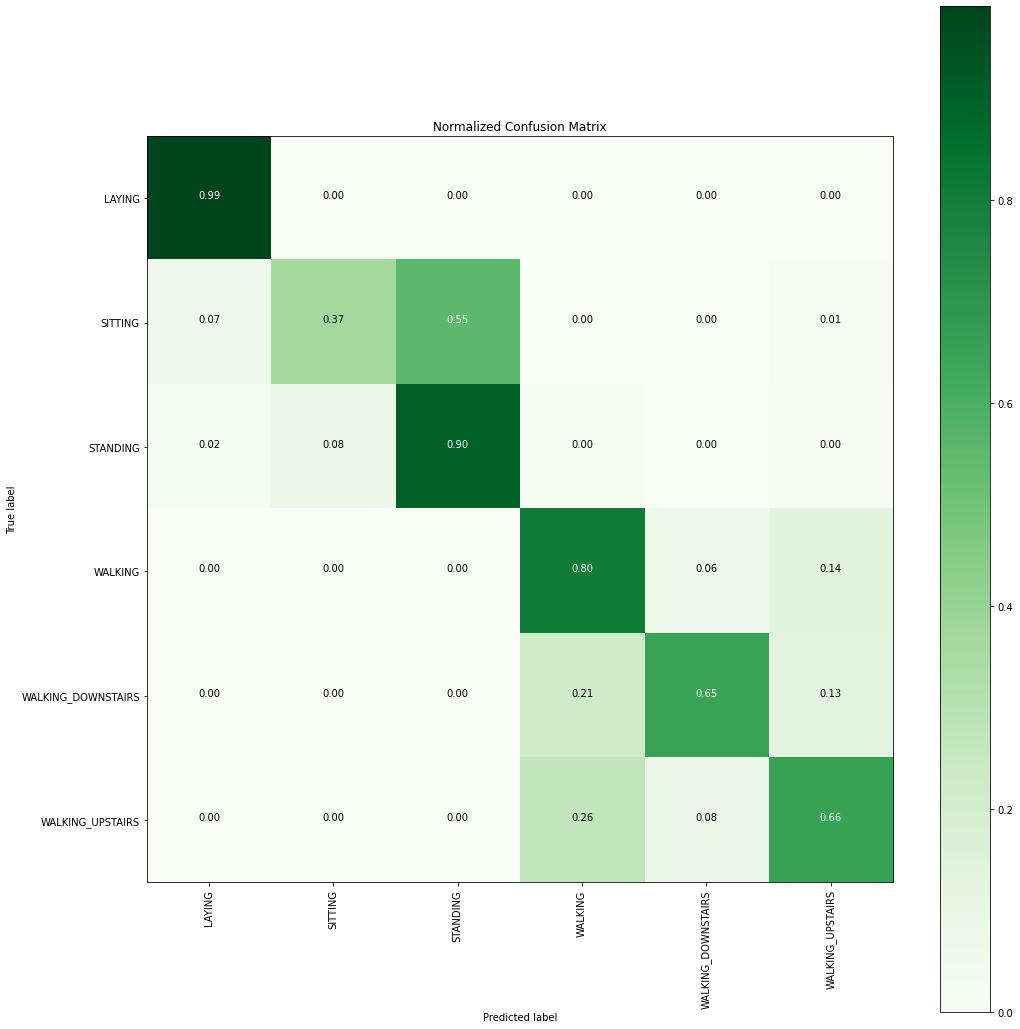


 F1 Score:0.7179609596402069


==> Best Estimator:
	RandomForestClassifier(max_depth=9, n_estimators=170)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 9, 'n_estimators': 170}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.7168115942028985
As epsilon = 2.0
training the model...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Done
==> training time:- 0:06:36.108623

Predicting test data
==> testing time:- 0:00:00.153486

==> Accuracy:- 0.7917034421888791


 ********Confusion Matrix********

 [[655   2   2   1   0   1]
 [ 26 319 270   0   0   4]
 [  0  81 521   1   0   2]
 [  0   0   0 505  30  57]
 [  0   0   0  74 329  53]
 [  0   0   0  75  29 362]]


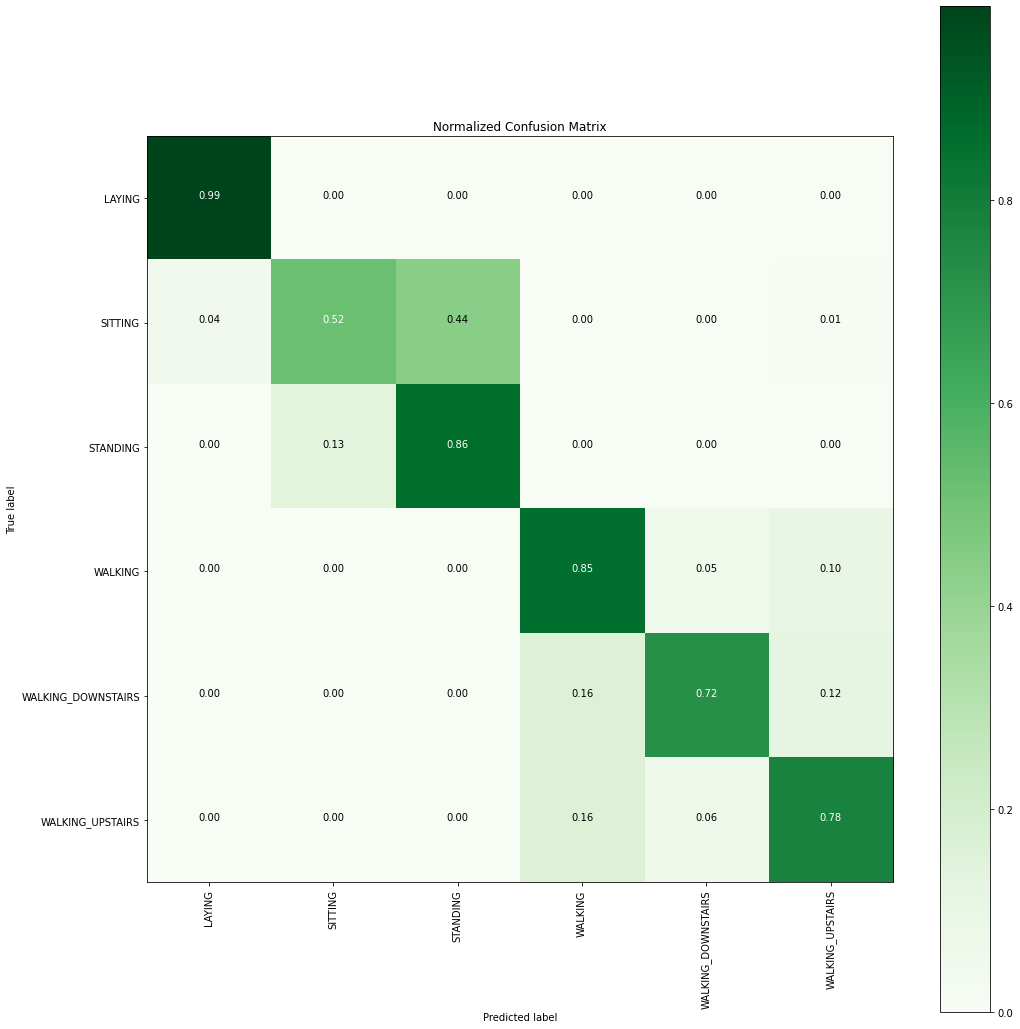


 F1 Score:0.7835727258809273


==> Best Estimator:
	RandomForestClassifier(max_depth=11, n_estimators=190)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 11, 'n_estimators': 190}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.7884057971014492
As epsilon = 2.5
training the model...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Done
==> training time:- 0:06:44.490041

Predicting test data
==> testing time:- 0:00:00.223725

==> Accuracy:- 0.8278905560458959


 ********Confusion Matrix********

 [[660   0   0   0   0   1]
 [ 26 369 220   0   0   4]
 [  0  69 535   0   0   1]
 [  0   0   0 512  31  49]
 [  0   0   0  47 359  50]
 [  0   0   0  64  23 379]]


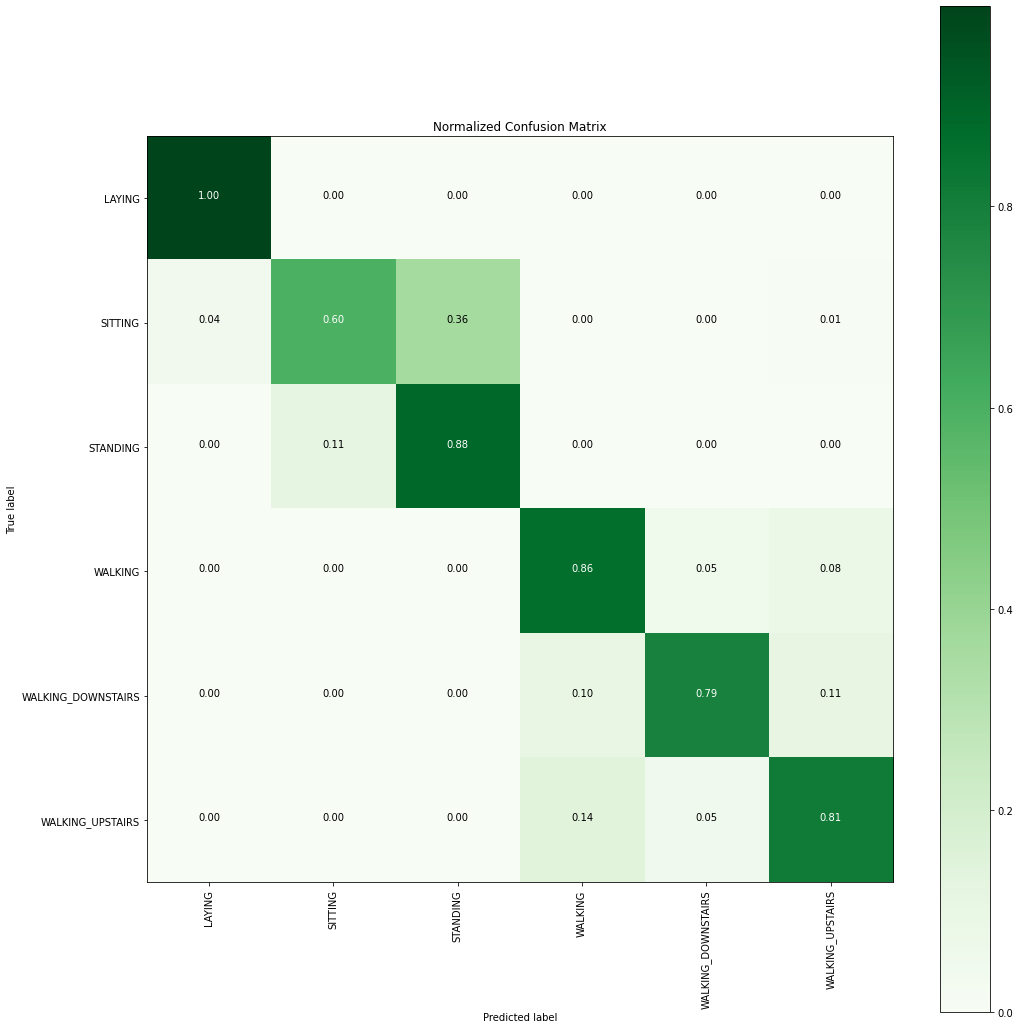


 F1 Score:0.8219754611801829


==> Best Estimator:
	RandomForestClassifier(max_depth=13, n_estimators=190)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 13, 'n_estimators': 190}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.828695652173913
As epsilon = 3
training the model...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Done
==> training time:- 0:06:23.823472

Predicting test data
==> testing time:- 0:00:00.119997

==> Accuracy:- 0.8505442777287437


 ********Confusion Matrix********

 [[658   1   0   0   0   2]
 [ 15 415 184   0   0   5]
 [  0  68 534   0   0   3]
 [  0   0   0 532  25  35]
 [  0   0   0  43 362  51]
 [  0   0   0  51  25 390]]


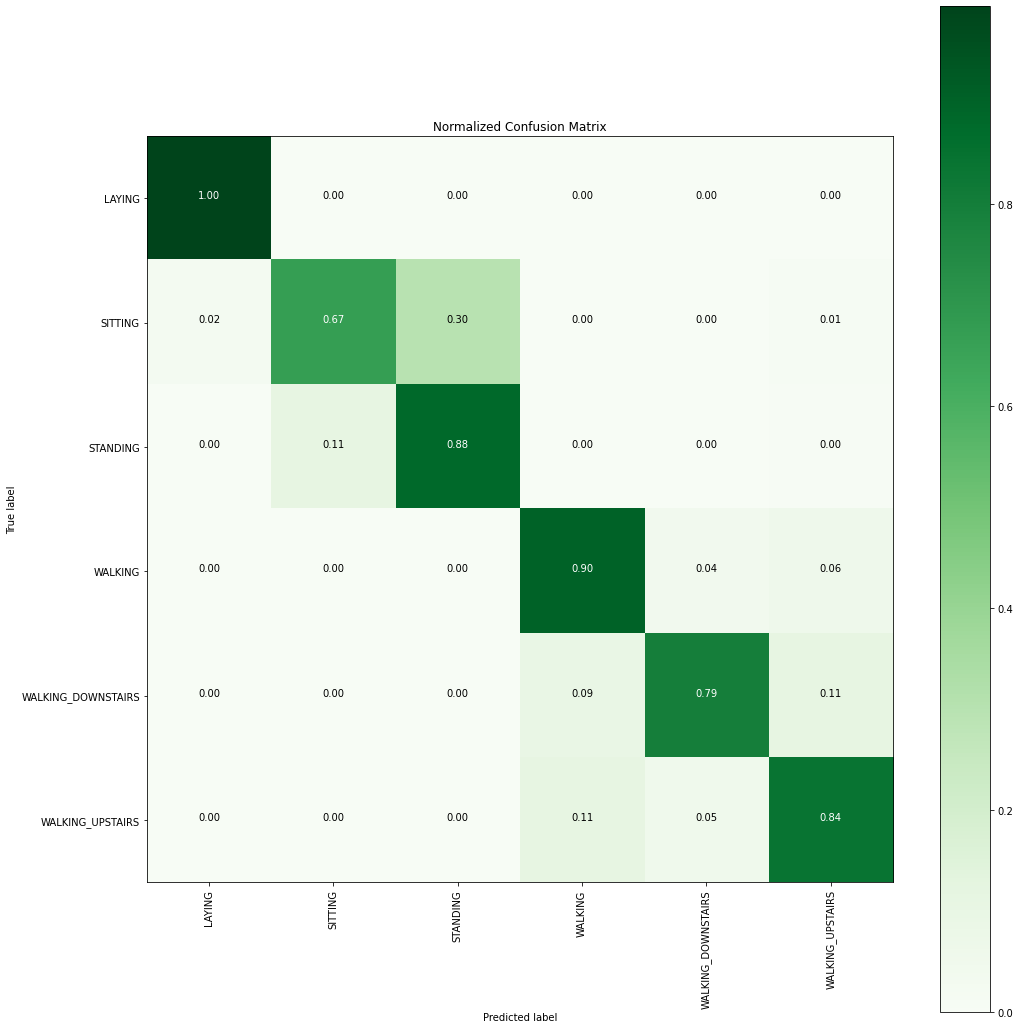


 F1 Score:0.8455414191314531


==> Best Estimator:
	RandomForestClassifier(max_depth=11, n_estimators=190)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 11, 'n_estimators': 190}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.8472463768115942
As epsilon = 4
training the model...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Done
==> training time:- 0:05:56.139676

Predicting test data
==> testing time:- 0:00:00.116420

==> Accuracy:- 0.8605472197705207


 ********Confusion Matrix********

 [[660   0   0   0   0   1]
 [  9 427 179   0   0   4]
 [  0  74 530   0   0   1]
 [  0   0   0 537  16  39]
 [  0   0   0  36 367  53]
 [  0   0   0  36  26 404]]


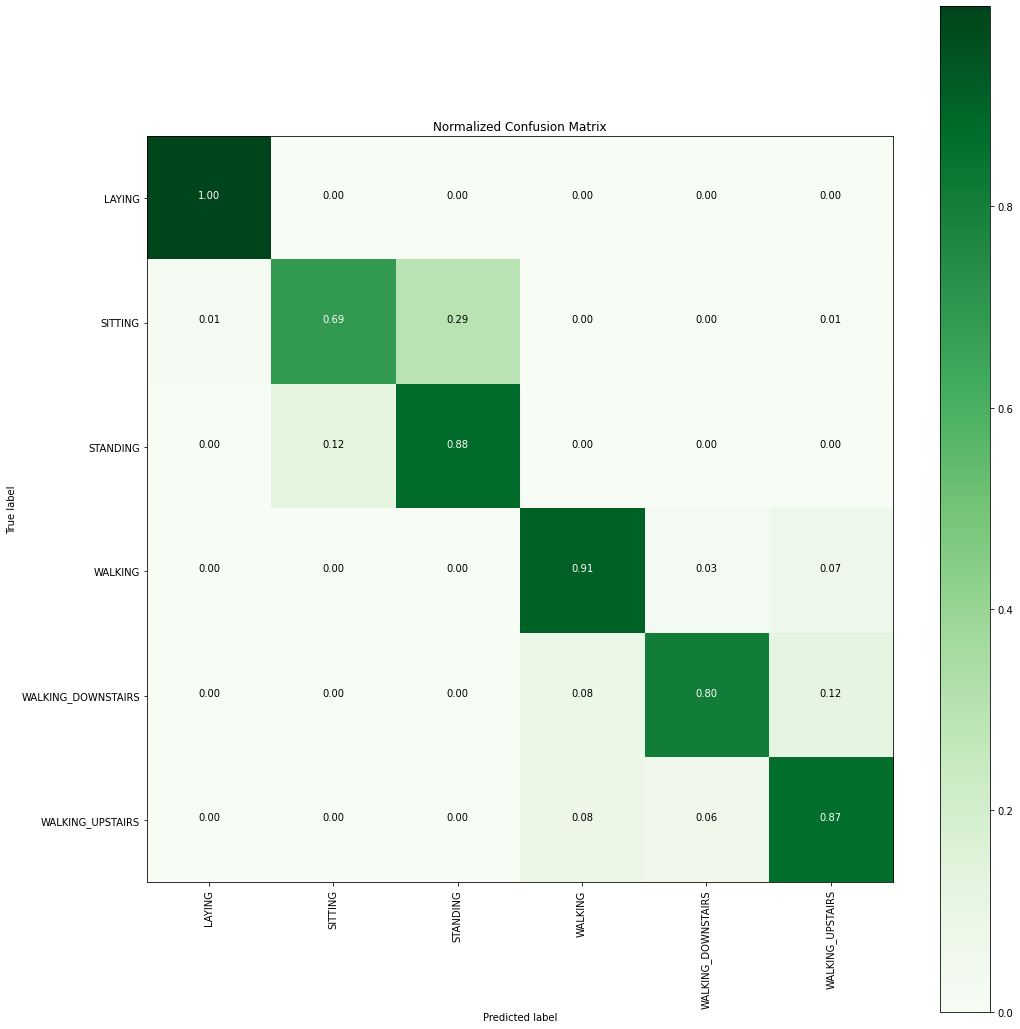


 F1 Score:0.856533125974646


==> Best Estimator:
	RandomForestClassifier(max_depth=13, n_estimators=150)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 13, 'n_estimators': 150}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.8736231884057972
As epsilon = 5
training the model...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Done
==> training time:- 0:05:58.817130

Predicting test data
==> testing time:- 0:00:00.064156

==> Accuracy:- 0.8840835539864667


 ********Confusion Matrix********

 [[660   0   0   0   0   1]
 [  7 467 140   0   0   5]
 [  0  66 539   0   0   0]
 [  0   0   0 546  21  25]
 [  0   0   0  34 370  52]
 [  0   0   0  24  19 423]]


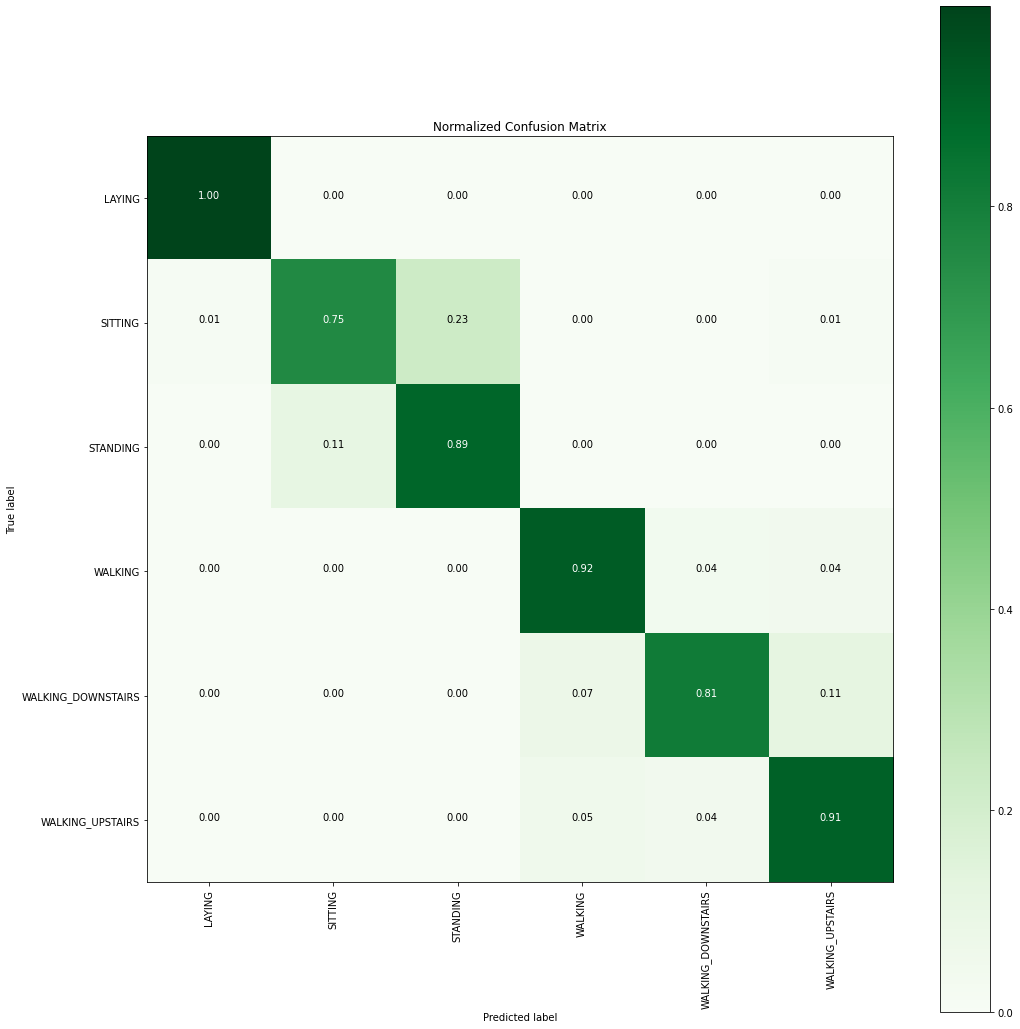


 F1 Score:0.8803701613776947


==> Best Estimator:
	RandomForestClassifier(max_depth=11, n_estimators=110)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 11, 'n_estimators': 110}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.8872463768115942


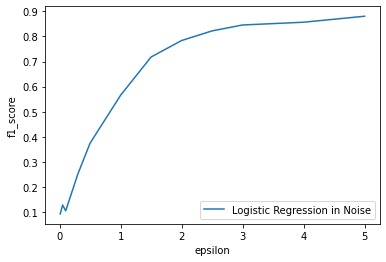

In [28]:
import warnings
# 収束しなかった場合のwarning
from sklearn.exceptions import ConvergenceWarning
# warningを無視する
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

epsilons = [0.01, 0.05, 0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 2.5, 3, 4, 5]
f1_array_random = list()


for epsilon in epsilons:
    # epsilon = 0.1
    # default sensitivity = 1.0
    
    print("As epsilon = {}".format(epsilon))

    X_train_noise = X_train.copy()
    X_test_noise = X_test.copy()

    X_train_noise_array = X_train_noise.values
    X_test_noise_array = X_test_noise.values

    for i in range(len(X_train_noise_array)):
        X_train_noise_array[i] = X_train_noise_array[i] + np.random.laplace(0, 1.0/epsilon, X_train_noise_array[i].shape)
    for j in range(len(X_test_noise_array)):
        X_test_noise_array[j] = X_test_noise_array[j] + np.random.laplace(0, 1.0/epsilon, X_test_noise_array[j].shape)
    
    params = {'n_estimators': np.arange(10,201,20), 'max_depth':np.arange(3,15,2)}
    rfc = RandomForestClassifier()
    rfc_grid = GridSearchCV(rfc, param_grid=params, cv=5, verbose=1, n_jobs=-1)
    rfc_grid_results, f1 = perform_model_epsilon(rfc_grid, X_train_noise_array, y_train, X_test_noise_array, y_test, class_labels=labels)

    f1_array_random.append(f1)
    
    # observe the attributes of the model 
    print_grid_search_attributes(rfc_grid_results['model'])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(epsilons, f1_array_random, label='Logistic Regression in Noise')
ax.set_xlabel('epsilon')
ax.set_ylabel('f1_score')
plt.legend(loc='best')
plt.show()


As epsilon = 6
training the model...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Done
==> training time:- 0:13:44.192978

Predicting test data
==> testing time:- 0:00:00.277169

==> Accuracy:- 0.8967343336275375


 ********Confusion Matrix********

 [[660   0   0   0   0   1]
 [  5 474 138   0   0   2]
 [  0  58 547   0   0   0]
 [  0   0   0 552  11  29]
 [  0   0   0  23 383  50]
 [  0   0   0  18  16 432]]


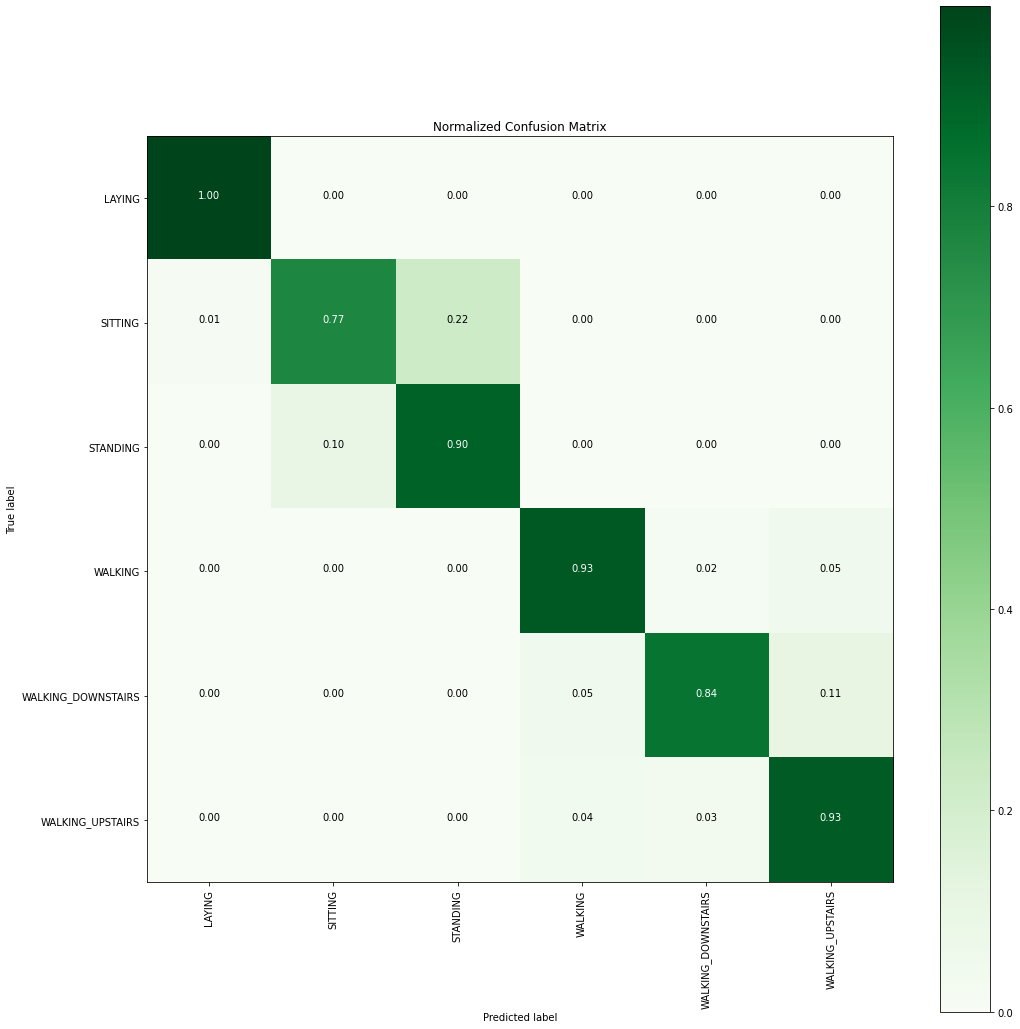


 F1 Score:0.8941622558121961


==> Best Estimator:
	RandomForestClassifier(max_depth=13, n_estimators=110)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 13, 'n_estimators': 110}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.9020289855072464
As epsilon = 7
training the model...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Done
==> training time:- 0:13:42.106165

Predicting test data
==> testing time:- 0:00:00.161886

==> Accuracy:- 0.9052662547808179


 ********Confusion Matrix********

 [[661   0   0   0   0   0]
 [  7 483 126   0   0   3]
 [  0  46 558   0   0   1]
 [  0   0   0 554  14  24]
 [  0   0   0  17 389  50]
 [  0   0   0  20  14 432]]


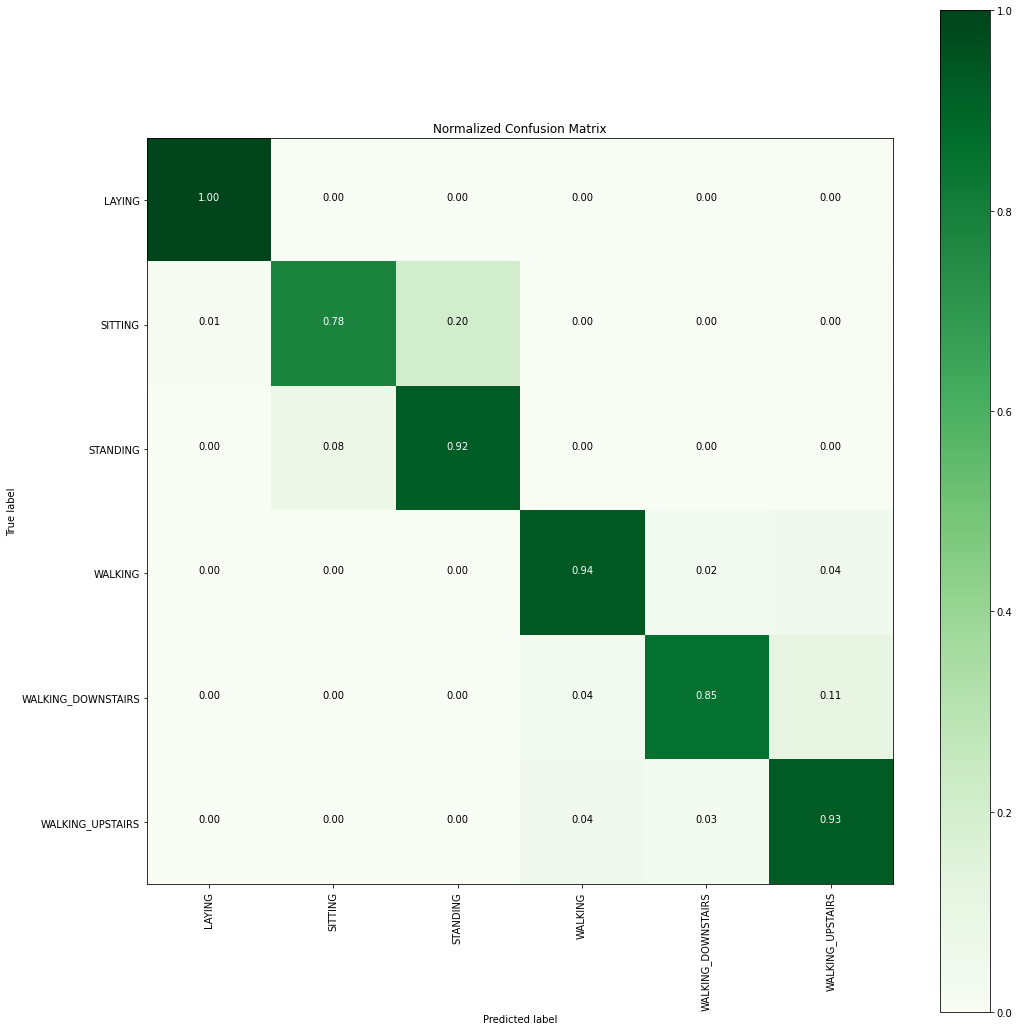


 F1 Score:0.9025018882616179


==> Best Estimator:
	RandomForestClassifier(max_depth=13, n_estimators=110)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 13, 'n_estimators': 110}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.9089855072463768
As epsilon = 8
training the model...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Done
==> training time:- 0:14:37.167694

Predicting test data
==> testing time:- 0:00:00.268606

==> Accuracy:- 0.909973521624007


 ********Confusion Matrix********

 [[661   0   0   0   0   0]
 [  6 498 113   0   0   2]
 [  0  57 547   0   0   1]
 [  0   0   0 563   9  20]
 [  0   0   0  25 390  41]
 [  0   0   0  19  13 434]]


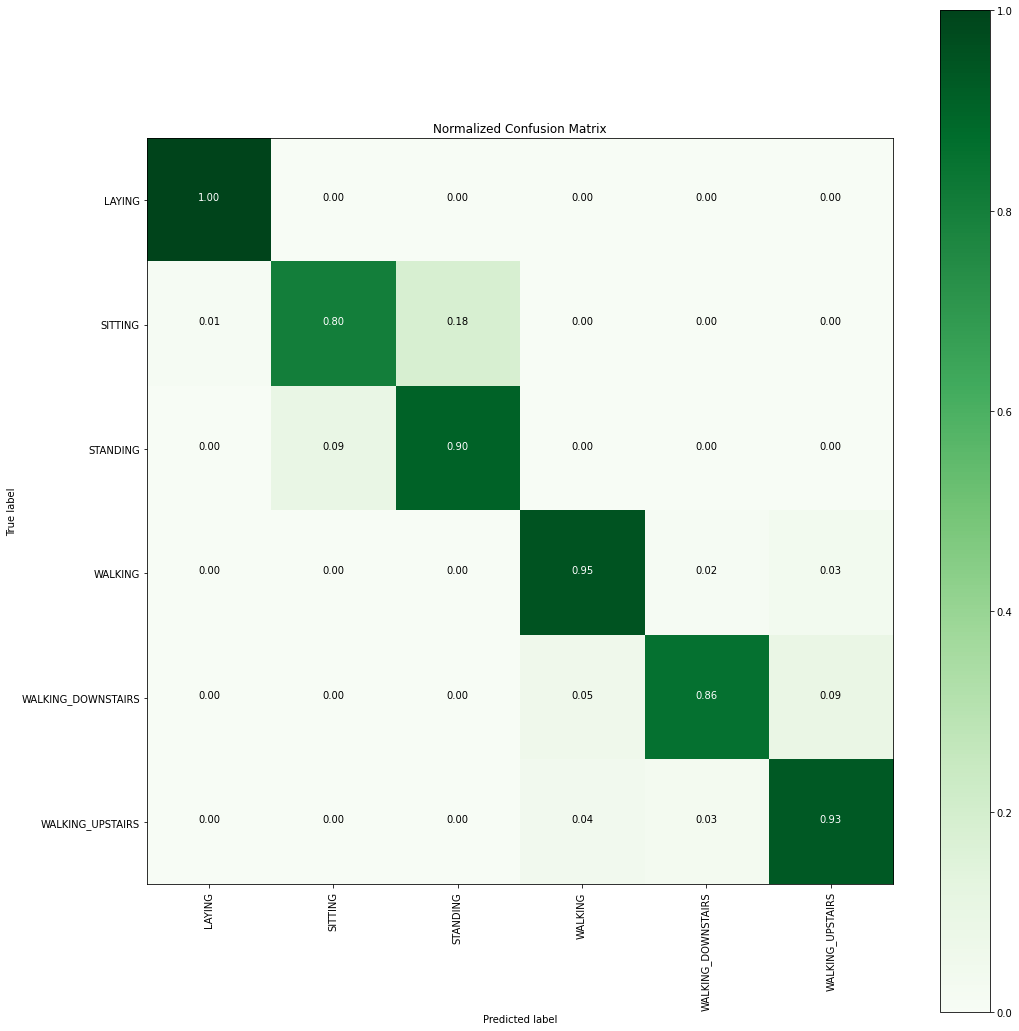


 F1 Score:0.9078056737804582


==> Best Estimator:
	RandomForestClassifier(max_depth=13, n_estimators=110)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 13, 'n_estimators': 110}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.9137681159420289
As epsilon = 9
training the model...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Done
==> training time:- 0:14:40.466001

Predicting test data
==> testing time:- 0:00:00.280709

==> Accuracy:- 0.92174168873198


 ********Confusion Matrix********

 [[660   0   0   0   0   1]
 [  4 515  98   0   0   2]
 [  0  49 556   0   0   0]
 [  0   0   0 566   7  19]
 [  0   0   0  13 399  44]
 [  0   0   0  17  12 437]]


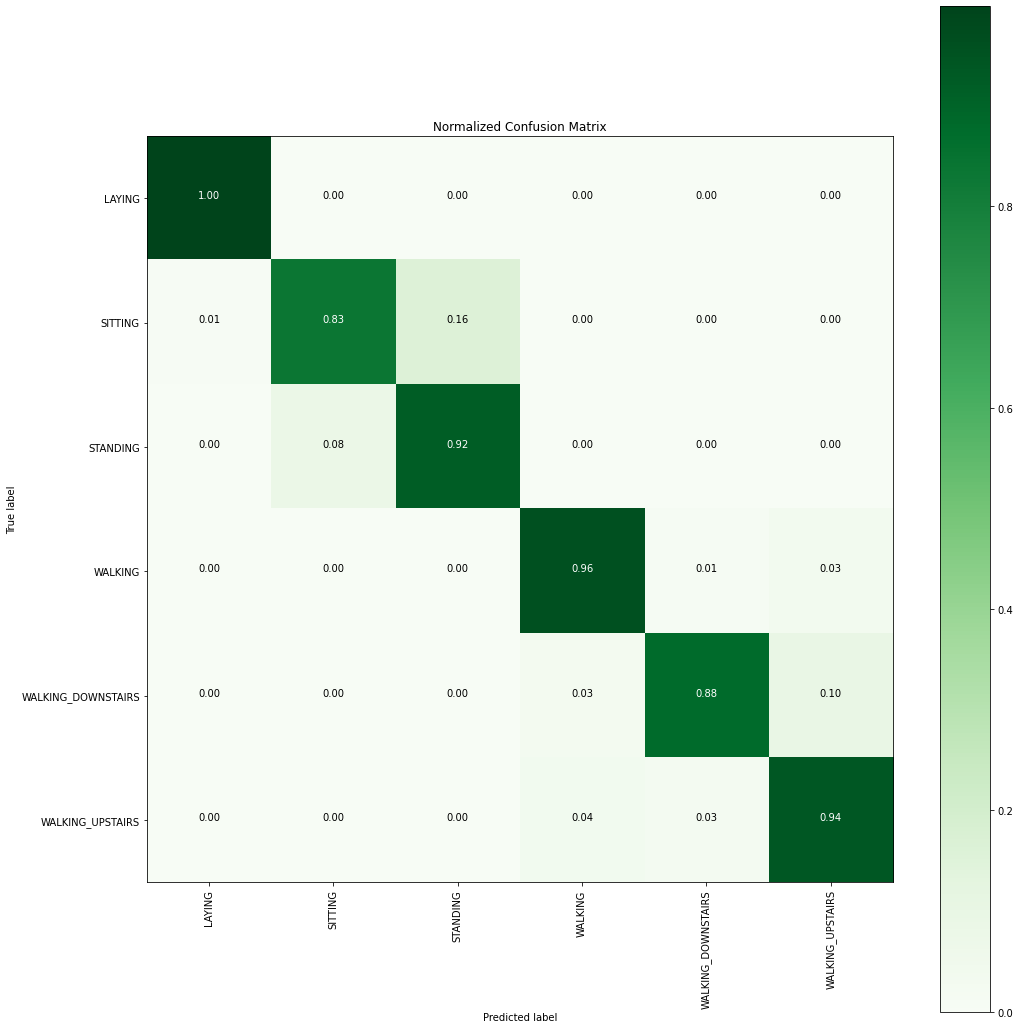


 F1 Score:0.919666848578632


==> Best Estimator:
	RandomForestClassifier(max_depth=13, n_estimators=150)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 13, 'n_estimators': 150}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.9198550724637681
As epsilon = 10
training the model...
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Done
==> training time:- 0:14:19.012993

Predicting test data
==> testing time:- 0:00:00.369332

==> Accuracy:- 0.922624301265078


 ********Confusion Matrix********

 [[660   0   0   0   0   1]
 [  6 514  97   0   0   2]
 [  0  61 544   0   0   0]
 [  0   0   0 569   6  17]
 [  0   0   0  16 406  34]
 [  0   0   0  13  10 443]]


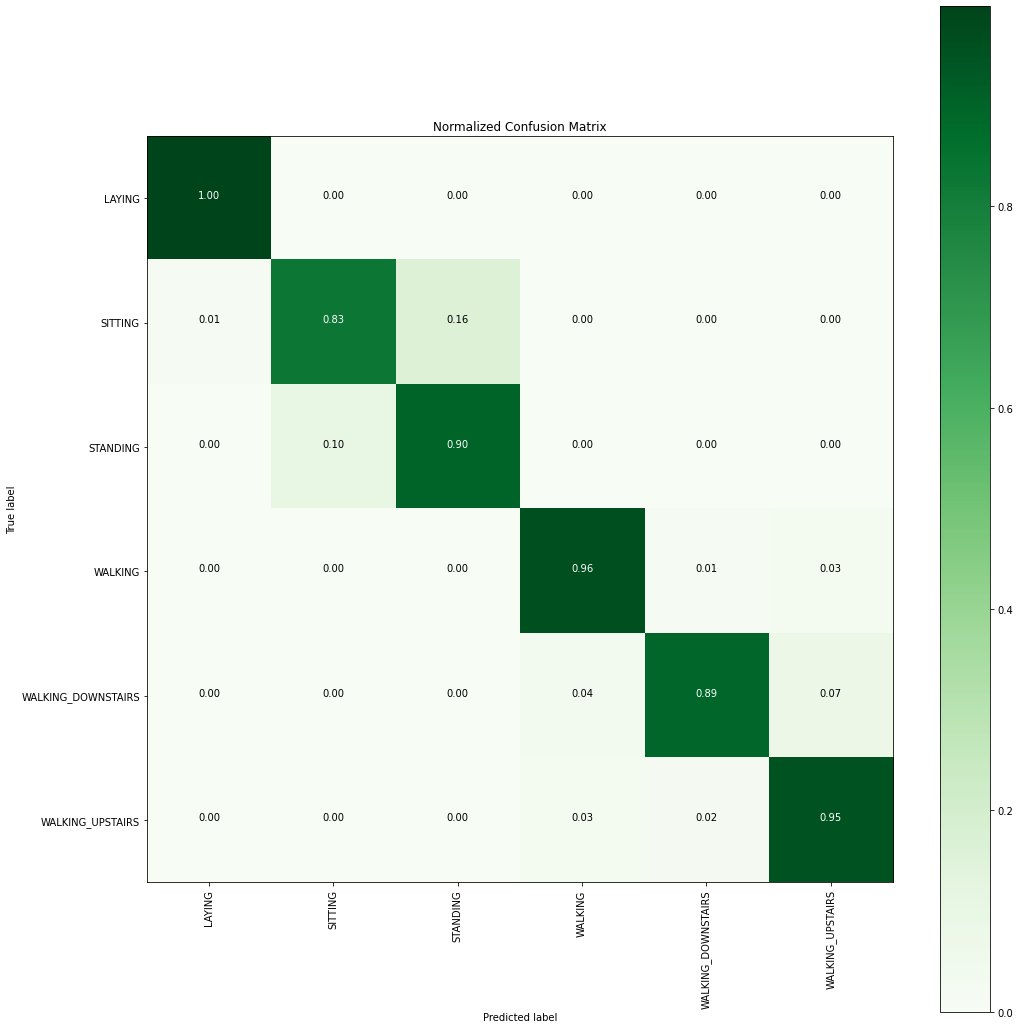


 F1 Score:0.921677317387707


==> Best Estimator:
	RandomForestClassifier(max_depth=13, n_estimators=150)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 13, 'n_estimators': 150}

==> No. of CrossValidation sets:
	Total nmber of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of Best estimator : 0.9265217391304347


ValueError: x and y must have same first dimension, but have shapes (17,) and (5,)

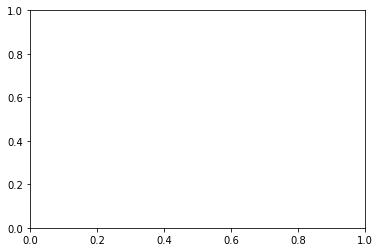

In [29]:
import warnings
# 収束しなかった場合のwarning
from sklearn.exceptions import ConvergenceWarning
# warningを無視する
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

epsilons = [6, 7, 8, 9, 10]
f1_array_random = list()


for epsilon in epsilons:
    # epsilon = 0.1
    # default sensitivity = 1.0
    
    print("As epsilon = {}".format(epsilon))

    X_train_noise = X_train.copy()
    X_test_noise = X_test.copy()

    X_train_noise_array = X_train_noise.values
    X_test_noise_array = X_test_noise.values

    for i in range(len(X_train_noise_array)):
        X_train_noise_array[i] = X_train_noise_array[i] + np.random.laplace(0, 1.0/epsilon, X_train_noise_array[i].shape)
    for j in range(len(X_test_noise_array)):
        X_test_noise_array[j] = X_test_noise_array[j] + np.random.laplace(0, 1.0/epsilon, X_test_noise_array[j].shape)
    
    params = {'n_estimators': np.arange(10,201,20), 'max_depth':np.arange(3,15,2)}
    rfc = RandomForestClassifier()
    rfc_grid = GridSearchCV(rfc, param_grid=params, n_jobs=-1, cv=5, verbose=1)
    rfc_grid_results, f1 = perform_model_epsilon(rfc_grid, X_train_noise_array, y_train, X_test_noise_array, y_test, class_labels=labels)
    
    f1_array_random.append(f1)

    # observe the attributes of the model 
    print_grid_search_attributes(rfc_grid_results['model'])
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot([0.01, 0.05, 0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 2.5, 3, 4, 5] + epsilons, f1_array_random, label='Random Forest in Noise')
ax.set_xlabel('epsilon')
ax.set_ylabel('f1_score')
plt.legend(loc='best')
plt.show()


## 6. Gradient Boosted Decision Trees With GridSearch

## 7. PATE
[参考URL](https://github.com/gmodena/tinydp)

sensitivity : 1.0 固定


As epsilon = 0.01
training the model...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Done
==> training time:- 0:06:27.316499

Predicting test data
==> testing time:- 0:00:00.999653

==> Accuracy:- 0.33627537511032657


 ********Confusion Matrix********

 [[330 328   2   1   0   0]
 [262 287  66   1   1   2]
 [194 205 206   0   0   0]
 [159 151 141 136   1   4]
 [104  91  75  93  88   5]
 [ 82  72  75  80  61  96]]


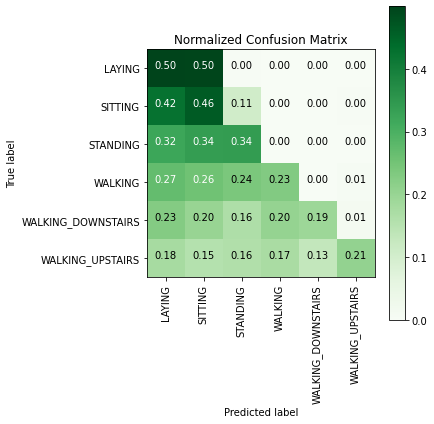

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.29      0.50      0.37       661
           SITTING       0.25      0.46      0.33       619
          STANDING       0.36      0.34      0.35       605
           WALKING       0.44      0.23      0.30       592
WALKING_DOWNSTAIRS       0.58      0.19      0.29       456
  WALKING_UPSTAIRS       0.90      0.21      0.34       466

          accuracy                           0.34      3399
         macro avg       0.47      0.32      0.33      3399
      weighted avg       0.45      0.34      0.33      3399

As epsilon = 0.05
training the model...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Done
==> training time:- 0:06:33.206323

Predicting test data
==> testing time:- 0:00:01.184476

==> Accuracy:- 0.4274786701971168


 ********Confusion Matrix********

 [[395 264   2   0   0   0]
 [202 349  64   1   1   2]
 [173 181 251   0   0   0]
 [144 135 114 193   1   5]
 [ 91  78  68  77 137   5]
 [ 81  65  65  72  55 128]]


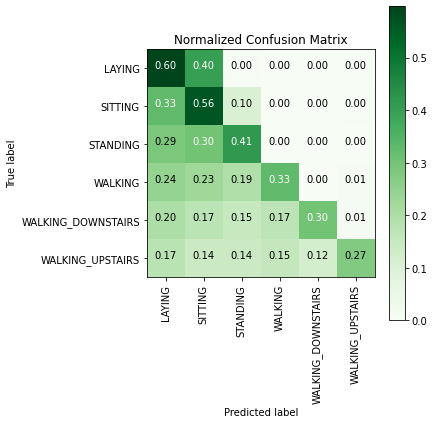

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.36      0.60      0.45       661
           SITTING       0.33      0.56      0.41       619
          STANDING       0.45      0.41      0.43       605
           WALKING       0.56      0.33      0.41       592
WALKING_DOWNSTAIRS       0.71      0.30      0.42       456
  WALKING_UPSTAIRS       0.91      0.27      0.42       466

          accuracy                           0.43      3399
         macro avg       0.55      0.41      0.43      3399
      weighted avg       0.53      0.43      0.43      3399

As epsilon = 0.1
training the model...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Done
==> training time:- 0:06:40.465518

Predicting test data
==> testing time:- 0:00:01.131120

==> Accuracy:- 0.5316269491026773


 ********Confusion Matrix********

 [[468 191   2   0   0   0]
 [163 387  65   1   1   2]
 [139 157 309   0   0   0]
 [108 105  87 285   1   6]
 [ 80  66  58  71 176   5]
 [ 70  53  57  59  45 182]]


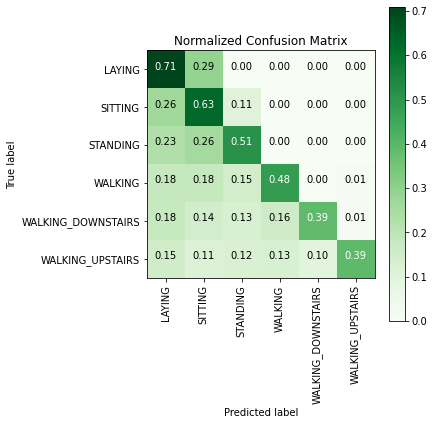

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.46      0.71      0.55       661
           SITTING       0.40      0.63      0.49       619
          STANDING       0.53      0.51      0.52       605
           WALKING       0.69      0.48      0.57       592
WALKING_DOWNSTAIRS       0.79      0.39      0.52       456
  WALKING_UPSTAIRS       0.93      0.39      0.55       466

          accuracy                           0.53      3399
         macro avg       0.63      0.52      0.53      3399
      weighted avg       0.61      0.53      0.53      3399

As epsilon = 0.3
training the model...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Done
==> training time:- 0:04:17.991504

Predicting test data
==> testing time:- 0:00:00.536877

==> Accuracy:- 0.8267137393350985


 ********Confusion Matrix********

 [[622  39   0   0   0   0]
 [ 46 516  52   0   1   4]
 [ 48  80 477   0   0   0]
 [ 34  28  35 489   1   5]
 [ 23  18  17  32 356  10]
 [ 28  25  25  19  19 350]]


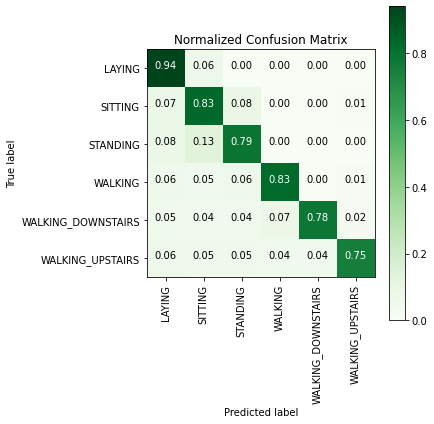

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.78      0.94      0.85       661
           SITTING       0.73      0.83      0.78       619
          STANDING       0.79      0.79      0.79       605
           WALKING       0.91      0.83      0.86       592
WALKING_DOWNSTAIRS       0.94      0.78      0.85       456
  WALKING_UPSTAIRS       0.95      0.75      0.84       466

          accuracy                           0.83      3399
         macro avg       0.85      0.82      0.83      3399
      weighted avg       0.84      0.83      0.83      3399

As epsilon = 0.5
training the model...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Done
==> training time:- 0:05:31.397344

Predicting test data
==> testing time:- 0:00:01.114383

==> Accuracy:- 0.9293909973521624


 ********Confusion Matrix********

 [[657   4   0   0   0   0]
 [ 18 544  52   0   0   5]
 [  9  52 544   0   0   0]
 [  9   4  11 563   1   4]
 [  6   3   5  14 417  11]
 [  5   5   6   6  10 434]]


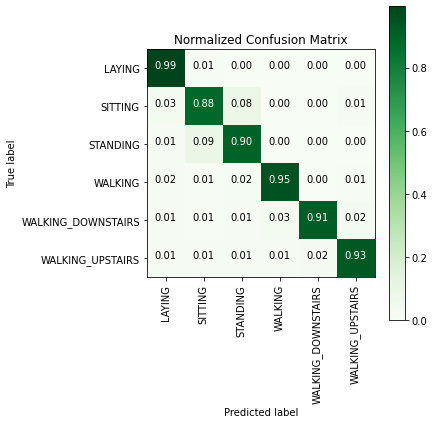

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.93      0.99      0.96       661
           SITTING       0.89      0.88      0.88       619
          STANDING       0.88      0.90      0.89       605
           WALKING       0.97      0.95      0.96       592
WALKING_DOWNSTAIRS       0.97      0.91      0.94       456
  WALKING_UPSTAIRS       0.96      0.93      0.94       466

          accuracy                           0.93      3399
         macro avg       0.93      0.93      0.93      3399
      weighted avg       0.93      0.93      0.93      3399

As epsilon = 1.0
training the model...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Done
==> training time:- 1:50:34.075017

Predicting test data
==> testing time:- 0:00:00.993195

==> Accuracy:- 0.9638128861429832


 ********Confusion Matrix********

 [[660   1   0   0   0   0]
 [  3 567  45   0   0   4]
 [  1  37 567   0   0   0]
 [  0   0   0 587   2   3]
 [  0   0   0   5 440  11]
 [  0   0   0   4   7 455]]


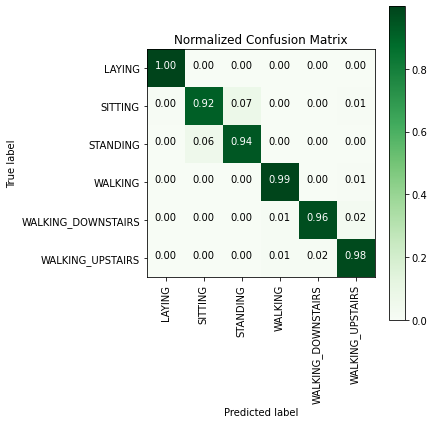

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       0.99      1.00      1.00       661
           SITTING       0.94      0.92      0.93       619
          STANDING       0.93      0.94      0.93       605
           WALKING       0.98      0.99      0.99       592
WALKING_DOWNSTAIRS       0.98      0.96      0.97       456
  WALKING_UPSTAIRS       0.96      0.98      0.97       466

          accuracy                           0.96      3399
         macro avg       0.96      0.96      0.96      3399
      weighted avg       0.96      0.96      0.96      3399

As epsilon = 1.5
training the model...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Done
==> training time:- 0:16:36.587041

Predicting test data
==> testing time:- 0:00:01.293372

==> Accuracy:- 0.9635186819652839


 ********Confusion Matrix********

 [[661   0   0   0   0   0]
 [  3 564  48   0   0   4]
 [  0  39 566   0   0   0]
 [  0   0   0 587   2   3]
 [  0   0   0   5 441  10]
 [  0   0   0   4   6 456]]


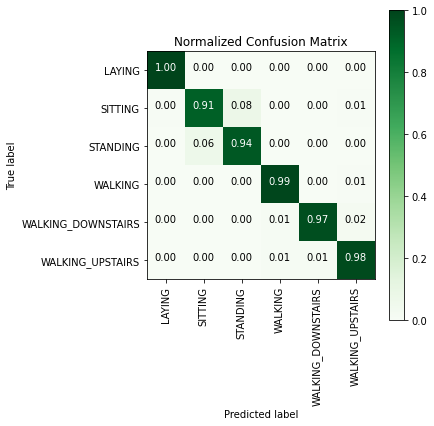

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       661
           SITTING       0.94      0.91      0.92       619
          STANDING       0.92      0.94      0.93       605
           WALKING       0.98      0.99      0.99       592
WALKING_DOWNSTAIRS       0.98      0.97      0.97       456
  WALKING_UPSTAIRS       0.96      0.98      0.97       466

          accuracy                           0.96      3399
         macro avg       0.96      0.96      0.96      3399
      weighted avg       0.96      0.96      0.96      3399

As epsilon = 2.0
training the model...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Done
==> training time:- 0:06:11.636612

Predicting test data
==> testing time:- 0:00:02.346674

==> Accuracy:- 0.9626360694321859


 ********Confusion Matrix********

 [[661   0   0   0   0   0]
 [  2 564  49   0   0   4]
 [  0  41 564   0   0   0]
 [  0   0   0 587   2   3]
 [  0   0   0   5 440  11]
 [  0   0   0   4   6 456]]


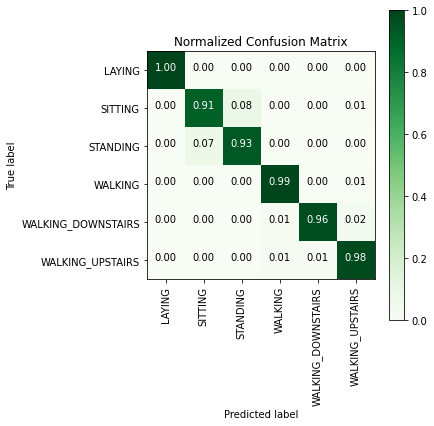

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       661
           SITTING       0.93      0.91      0.92       619
          STANDING       0.92      0.93      0.93       605
           WALKING       0.98      0.99      0.99       592
WALKING_DOWNSTAIRS       0.98      0.96      0.97       456
  WALKING_UPSTAIRS       0.96      0.98      0.97       466

          accuracy                           0.96      3399
         macro avg       0.96      0.96      0.96      3399
      weighted avg       0.96      0.96      0.96      3399

As epsilon = 2.5
training the model...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Done
==> training time:- 0:03:59.520981

Predicting test data
==> testing time:- 0:00:00.750392

==> Accuracy:- 0.9623418652544866


 ********Confusion Matrix********

 [[661   0   0   0   0   0]
 [  2 563  50   0   0   4]
 [  0  40 565   0   0   0]
 [  0   0   0 587   2   3]
 [  0   0   0   6 439  11]
 [  0   0   0   4   6 456]]


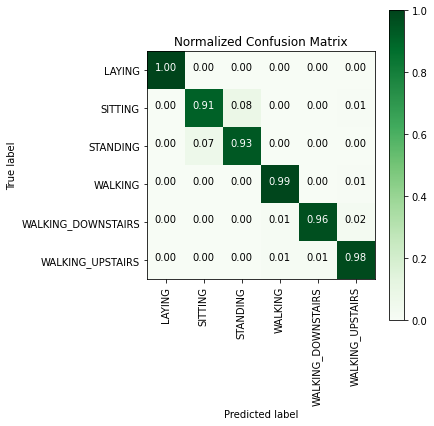

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       661
           SITTING       0.93      0.91      0.92       619
          STANDING       0.92      0.93      0.93       605
           WALKING       0.98      0.99      0.99       592
WALKING_DOWNSTAIRS       0.98      0.96      0.97       456
  WALKING_UPSTAIRS       0.96      0.98      0.97       466

          accuracy                           0.96      3399
         macro avg       0.96      0.96      0.96      3399
      weighted avg       0.96      0.96      0.96      3399

As epsilon = 3
training the model...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Done
==> training time:- 0:05:12.853588

Predicting test data
==> testing time:- 0:00:01.485191

==> Accuracy:- 0.9623418652544866


 ********Confusion Matrix********

 [[661   0   0   0   0   0]
 [  2 564  49   0   0   4]
 [  0  40 565   0   0   0]
 [  0   0   0 587   2   3]
 [  0   0   0   6 439  11]
 [  0   0   0   4   7 455]]


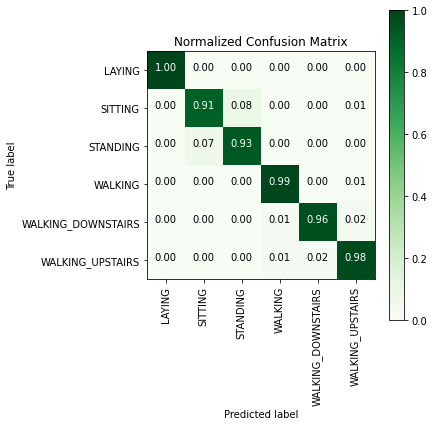

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       661
           SITTING       0.93      0.91      0.92       619
          STANDING       0.92      0.93      0.93       605
           WALKING       0.98      0.99      0.99       592
WALKING_DOWNSTAIRS       0.98      0.96      0.97       456
  WALKING_UPSTAIRS       0.96      0.98      0.97       466

          accuracy                           0.96      3399
         macro avg       0.96      0.96      0.96      3399
      weighted avg       0.96      0.96      0.96      3399

As epsilon = 4
training the model...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Done
==> training time:- 0:07:55.858107

Predicting test data
==> testing time:- 0:00:01.712536

==> Accuracy:- 0.9623418652544866


 ********Confusion Matrix********

 [[661   0   0   0   0   0]
 [  2 565  48   0   0   4]
 [  0  41 564   0   0   0]
 [  0   0   0 587   2   3]
 [  0   0   0   6 439  11]
 [  0   0   0   4   7 455]]


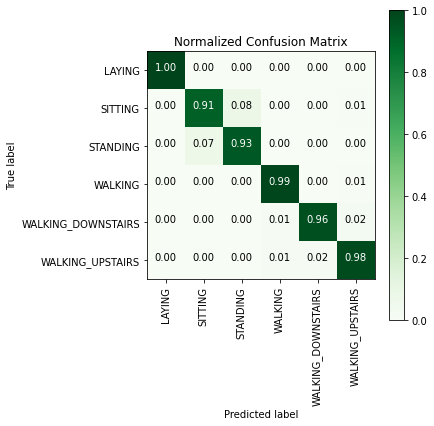

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       661
           SITTING       0.93      0.91      0.92       619
          STANDING       0.92      0.93      0.93       605
           WALKING       0.98      0.99      0.99       592
WALKING_DOWNSTAIRS       0.98      0.96      0.97       456
  WALKING_UPSTAIRS       0.96      0.98      0.97       466

          accuracy                           0.96      3399
         macro avg       0.96      0.96      0.96      3399
      weighted avg       0.96      0.96      0.96      3399

As epsilon = 5
training the model...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/ryuseifujimoto/.asdf/installs/python/3.9.8/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

Done
==> training time:- 0:08:00.306963

Predicting test data
==> testing time:- 0:00:01.369692

==> Accuracy:- 0.9626360694321859


 ********Confusion Matrix********

 [[661   0   0   0   0   0]
 [  2 565  48   0   0   4]
 [  0  40 565   0   0   0]
 [  0   0   0 587   2   3]
 [  0   0   0   6 439  11]
 [  0   0   0   4   7 455]]


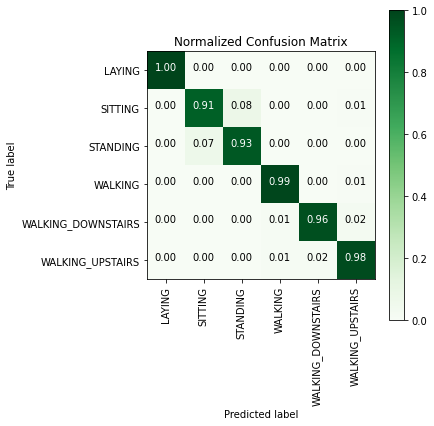

****************| Classifiction Report |****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       661
           SITTING       0.93      0.91      0.92       619
          STANDING       0.92      0.93      0.93       605
           WALKING       0.98      0.99      0.99       592
WALKING_DOWNSTAIRS       0.98      0.96      0.97       456
  WALKING_UPSTAIRS       0.96      0.98      0.97       466

          accuracy                           0.96      3399
         macro avg       0.96      0.96      0.96      3399
      weighted avg       0.96      0.96      0.96      3399



In [17]:
from dp.ensemble import PrivateClassifier
from sklearn.metrics import classification_report

X_private = X_train.copy().values
y_private = y_train.copy().values
X_public = X_test.copy().values
y_public = y_test.copy().values

# parameters = {'epsilon': [0.01, 0.05, 0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 2.5, 3, 4, 5]}

epsilons = [0.01, 0.05, 0.1, 0.3, 0.5, 1.0, 1.5, 2.0, 2.5, 3, 4, 5]

for epsilon in epsilons:
    
    print("As epsilon = {}".format(epsilon))

    # n_estimators: 訓練データを割り切れる数
    private_clf = PrivateClassifier(n_estimators=10, epsilon=epsilon ,random_state=1)
    private_clf_grid = GridSearchCV(private_clf, param_grid={}, n_jobs=-1, cv=5, verbose=1)
    private_clf_results = perform_model(private_clf_grid, X_private, y_private, X_public, y_public, class_labels=labels)

# observe the attributes of the model 
# print_grid_search_attributes(private_clf_grid_results['model'])


In [16]:
from syft.frameworks.torch.dp import pate

data_dep_eps, data_ind_eps = pate.perform_analysis(teacher_preds=private_clf.teacher_preds,
                                                   indices=y_public,
                                                   noise_eps=0.1, delta=1e-5)
print("Data Independent Epsilon:", data_ind_eps)
print("Data Dependent Epsilon:", data_dep_eps)

ModuleNotFoundError: No module named 'syft.frameworks'

## 8. Comparing all models